In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import fnmatch
import pickle
from astroquery.gaia import Gaia
# ASTROPHY Imports
import astropy 
from astropy import stats
# from astropy.table import Table
# from astropy.io import fits
# from sherpa.astro import ui
# # CIAO Imports
# import ciao_contrib.runtool
# from ciao_contrib.runtool import *
# # CUSTOM Imports
# from data_extraction_functions import *
# from data_exploration_functions import *
# from data_representation_functions import *
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

pd.set_option('display.max_columns', None)

In [3]:
# Set ID
set_id = set_widget.value
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*nE16*none*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='Histogram File :',disabled=False); input_widget

Dropdown(description='Histogram File :', options=('hist2D-Full-nE16-nt24-normnone.pkl', 'hist3D-Full-nE16-nt24…

In [4]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()
#Load eventfiles
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_global = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_properties_global['obsreg_id'] = df_properties_global['obsid'].astype(str) + '_' + df_properties_global['region_id'].astype(str)
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')

# print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
# print("Number of Property Sets: ", df_properties_group.ngroups)

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))
print("Number of Full Property Sets: ", len(df_properties_global))

df_properties_global.head()

Number of Features:  95473
Number of Property Sets:  95473
Number of Full Property Sets:  130232


name        ra        dec  err_ellipse_r0  err_ellipse_r1   
0  2CXO J000000.5-575830  0.002735 -57.975181        2.819565        1.667655  \
1  2CXO J000001.7+003824  0.007280   0.640146        1.093394        0.871849   
2  2CXO J000002.4+004444  0.010189   0.745732        0.746484        0.723548   
3  2CXO J000002.4+321750  0.010280  32.297465        1.067836        0.944977   
4  2CXO J000002.9-350332  0.012314 -35.059185        0.855386        0.735828   

   err_ellipse_ang  significance likelihood_class  conf_flag  sat_src_flag   
0        91.090421      8.522222             TRUE       True         False  \
1       104.849964      5.485207             TRUE      False         False   
2        34.468703      5.774224             TRUE      False         False   
3       115.769199      5.028571             TRUE      False         False   
4       172.590089     16.266113             TRUE      False         False   

   streak_src_flag   flux_aper_b  flux_aper_lolim_b  flux_aper_hilim_b   
0            False  3.434509e-14       2.608488e-14       4.217055e-14  \
1            False  1.662168e-14       1.325999e-14       1.979660e-14   
2            False  1.448938e-14       1.200382e-14       1.682874e-14   
3            False  0.000000e+00       0.000000e+00       2.181124e-15   
4            False  3.589425e-13       3.363125e-13       3.815725e-13   

   flux_aper_w  flux_aper_lolim_w  flux_aper_hilim_w  flux_aper_avg_b   
0          NaN                NaN                NaN     3.434509e-14  \
1          NaN                NaN                NaN     1.662168e-14   
2          NaN                NaN                NaN     1.448938e-14   
3          NaN                NaN                NaN     0.000000e+00   
4          NaN                NaN                NaN     3.589425e-13   

   flux_aper_avg_lolim_b  flux_aper_avg_hilim_b  flux_aper_avg_w   
0           2.608488e-14           4.217055e-14              NaN  \
1           1.325999e-14           1.979660e-14              NaN   
2           1.200382e-14           1.682874e-14              NaN   
3           0.000000e+00           2.181124e-15              NaN   
4           3.363125e-13           3.815725e-13              NaN   

   flux_aper_avg_lolim_w  flux_aper_avg_hilim_w  obsid  obi   
0                    NaN                    NaN   9335    0  \
1                    NaN                    NaN  11591    0   
2                    NaN                    NaN  11591    0   
3                    NaN                    NaN  20515    0   
4                    NaN                    NaN  15712    0   

               gti_obs              gti_end  region_id      theta         phi   
0  2009-03-16T22:23:26  2009-03-17T06:52:35         26  11.120887  118.877460  \
1  2009-08-13T14:18:14  2009-08-13T20:58:47          1   4.582817    8.452166   
2  2009-08-13T14:18:14  2009-08-13T20:58:47         22   2.397741  240.839479   
3  2018-02-04T04:46:58  2018-02-04T11:44:40          8   6.908982   27.688648   
4  2013-10-23T21:00:50  2013-10-23T23:48:38          4   5.606038  162.925240   

   flux_significance_b  flux_significance_w  likelihood_b  likelihood_w   
0             8.522222                  NaN    139.665996           NaN  \
1             5.485207                  NaN    110.292372           NaN   
2             5.774224                  NaN    224.178117           NaN   
3             5.028571                  NaN     90.630192           NaN   
4            16.266113                  NaN   1506.051665           NaN   

   conf_code  extent_code  sat_src_flag.1  streak_src_flag.1  var_code   
0         15            0           False              False         0  \
1          0            0           False              False         0   
2          1            0           False              False         0   
3          1            0           False              False         0   
4          0           16           False              False         0   

   major_

In [5]:
# Load DBSCAN RESULT
files = os.listdir(f'{global_path}/{set_id}/')
dbscan_files1 = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*hist2D*PCA15*11*EPS2.1*MS22*csv')][0] #PCA 2D
dbscan_files2 = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*11*EPS1.65*MS28*csv')][0]  #PCA 3D
dbscan_files3 = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*XAE*perp40*it3000*EPS1.6-*MS25*csv')][0]  # XAE 2D
dbscan_files4 = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*XAE*12*EPS1.9*MS24*csv')][0]  # XAE 3D
df_tsne1 = pd.read_csv(f'{global_path}/{set_id}/{dbscan_files1}')
df_tsne2 = pd.read_csv(f'{global_path}/{set_id}/{dbscan_files2}')
df_tsne3 = pd.read_csv(f'{global_path}/{set_id}/{dbscan_files3}')
df_tsne4 = pd.read_csv(f'{global_path}/{set_id}/{dbscan_files4}')
df_tsne1 = df_tsne1.sort_values(by='cluster', ascending=True) 
df_tsne2 = df_tsne2.sort_values(by='cluster', ascending=True) 
df_tsne3 = df_tsne3.sort_values(by='cluster', ascending=True) 
df_tsne4 = df_tsne4.sort_values(by='cluster', ascending=True) 

#####SELECTED ANOMALIES
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218','13828_596']

# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10','9072_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']

ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']

# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
lin = ['4062_31', '13454_56','20635_58','24604_8'] 
xue = ['957_208', '3389_274','15211_38','15214_29']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59','21831_22']
vasquez = ['2025_39','9548_14','15113_59','21831_22']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015

flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']

NEW = ['23022_122']

tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez = df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding)]
tsne_nandra = df_tsne.loc[df_tsne['obsreg_id'].isin(nandra)]
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares + flares_maybe + NEW)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva + dips_maybe)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

tsne_new = df_tsne.loc[df_tsne['obsreg_id'].isin(NEW)] 


anomalies = pd.concat([tsne_lin,tsne_irwin,tsne_glennie,tsne_jonker,tsne_vasquez,tsne_xue,tsne_goulding,tsne_nandra,tsne_flares,tsne_m101ulx, tsne_distefano, tsne_moredips,tsne_parmar,tsne_new])
anomalies.head(50)


NameError: name 'df_tsne' is not defined

In [5]:
paper_path = '/Users/steven/Desktop/Paper/thesis/'
xmatch_file = 'xmatch.csv'
dips_file = 'dip-properties-Full.csv'
flares_file = 'flare-properties-Full.csv'

In [6]:
#Rafael asked for data
df_f = pd.read_csv(paper_path+flares_file)
flares_true = list(df_f[df_f['var_index_b']>9]['obsreg_id'])[0:500]
flares_false = list(df_f[df_f['var_index_b']<4]['obsreg_id'])[0:500]

df_eventfiles_flarestrue = df_eventfiles_input[df_eventfiles_input['obsreg_id'].isin(list(flares_true))]
df_eventfiles_flaresfalse = df_eventfiles_input[df_eventfiles_input['obsreg_id'].isin(list(flares_false))]

df_eventfiles_flarestrue.to_csv(paper_path+'trueflares.csv')
df_eventfiles_flaresfalse.to_csv(paper_path+'falseflares.csv')

# print(len(df_flares_true))
# print(len(df_flares_false))
# df_flares_true.head()


In [7]:
df_x = pd.read_csv(paper_path+xmatch_file)
df_d = pd.read_csv(paper_path+dips_file)
df_f = pd.read_csv(paper_path+flares_file)


print(len(df_x),len(df_d),len(df_f))

df_x.head()

/var/folders/q1/jbx7qj7s0dxbh7nv02nfvc680000gn/T/ipykernel_42940/3641068286.py:1: DtypeWarning: Columns (57,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_x = pd.read_csv(paper_path+xmatch_file)


387441 4259 4697


CSC21P_name        ra        dec likelihood_class  extent_flag   
0  2CXO J000000.1+623124  0.000574  62.523404             TRUE        False  \
1  2CXO J000000.2-501250  0.000772 -50.214007             TRUE        False   
2  2CXO J000000.3+321702  0.001488  32.284135             TRUE        False   
3  2CXO J000000.5+321232  0.002214  32.209102             TRUE        False   
4  2CXO J000000.5-575830  0.002735 -57.975181             TRUE        False   

   err_ellipse_r0  err_ellipse_r1  err_ellipse_ang  significance   
0        1.571081        1.381115       158.719546      3.411765  \
1        1.846074        1.846072         0.000000      2.750000   
2        1.410367        1.043504        88.252971      3.200000   
3        1.433781        0.839883       170.567508      2.756757   
4        2.819565        1.667655        91.090421      8.522222   

    flux_aper_b  flux_aper_lolim_b  flux_aper_hilim_b   flux_aper_h   
0  7.101134e-15       5.055045e-15       9.026866e-15  6.564634e-15  \
1  1.363699e-15       5.654362e-16       2.128701e-15  1.184429e-15   
2  3.755970e-15       5.564400e-16       6.955500e-15  8.798816e-15   
3  1.522626e-14       6.471160e-15       2.398136e-14  0.000000e+00   
4  3.434509e-14       2.608488e-14       4.217055e-14  6.944387e-15   

   flux_aper_lolim_h  flux_aper_hilim_h   flux_aper_m  flux_aper_lolim_m   
0       4.335136e-15       8.670272e-15  3.586472e-16       1.062658e-16  \
1       3.675813e-16       1.960433e-15  3.818123e-16       1.551113e-16   
2       4.799354e-15       1.259830e-14  2.263133e-15       1.234436e-15   
3       0.000000e+00       1.288344e-15  9.019349e-16       2.338350e-16   
4       2.893494e-16       1.359942e-14  7.104392e-15       5.505904e-15   

   flux_aper_hilim_m   flux_aper_s  flux_aper_lolim_s  flux_aper_hilim_s   
0       6.110285e-16  4.242448e-16       0.000000e+00       8.484895e-16  \
1       6.085134e-16           NaN                NaN                NaN   
2       3.291830e-15  0.000000e+00       0.000000e+00       6.098377e-16   
3       1.570035e-15  1.326156e-14       3.729815e-15       2.279331e-14   
4       8.614075e-15  1.855904e-14       1.553311e-14       2.158497e-14   

   flux_aper_w  flux_aper_lolim_w  flux_aper_hilim_w  csc2.1_flag   
0          NaN                NaN                NaN         True  \
1          NaN                NaN                NaN         True   
2          NaN                NaN                NaN         True   
3          NaN                NaN                NaN         True   
4          NaN                NaN                NaN         True   

    PS21P_objID  PS21P_ippObjID  PS21P_ra  PS21P_dec  Sep_PS21P_CSC21P   
0           NaN             NaN       NaN        NaN               NaN  \
1           NaN             NaN       NaN        NaN               NaN   
2           NaN             NaN       NaN        NaN               NaN   
3  1.466500e+17    1.978477e+14  0.002355  32.209256          0.700509   
4           NaN             NaN       NaN        NaN               NaN   

   PS21P_g    PS21P_r  PS21P_i    PS21P_z  GAIA21P_source_id  GAIA21P_ra   
0      NaN        NaN      NaN        NaN                NaN         NaN  \
1      NaN        NaN      NaN        NaN                NaN         NaN   
2      NaN        NaN      NaN        NaN                NaN         NaN   
3   17.948  17.410299  17.0224  16.567101       2.873826e+18    0.002357   
4      NaN        NaN      NaN        NaN       4.919344e+18    0.003645   

   GAIA21P_dec  Sep_GAIA21P_CSC21P  GAIA21P_g  LEG21P_LS_ID  LEG21P_OBJID   
0          NaN                 NaN        NaN           NaN           NaN  \
1          NaN                 NaN        NaN  4.398079e+16          24.0   
2          NaN                 NaN        NaN  4.398259e+16          38.0   
3    32.209256            0.704206  20.460768  4.398259e+16          48.0   
4   -57.975021            1.830076  19.186714  4.398068e+16          99.0   

   LEG21

In [8]:
var_index_cut = 5
df_dips = df_d[df_d['var_index_b']>=var_index_cut]
df_flares= df_f[df_f['var_index_b']>=var_index_cut]

# df_dips = df_d[df_d['var_index_b']>=var_index_cut]
# df_flares= df_f[df_f['var_index_b']<=var_index_cut]

print(len(df_x),len(df_dips),len(df_flares))

387441 1103 3878


In [9]:
df_dips2 = df_dips.merge(df_x, how='left', left_on='name', right_on='CSC21P_name')
df_flares2 = df_flares.merge(df_x, how='left', left_on='name', right_on='CSC21P_name')

dips_ids =  df_dips2['GAIA21P_source_id'].dropna().astype(int)
flares_ids = df_flares2['GAIA21P_source_id'].dropna().astype(int)

print(len(dips_ids))
print(len(flares_ids))
df_dips2.head()


948
3021


name      ra_x      dec_x  err_ellipse_r0_x   
0  2CXO J000136.1+130639  0.400463  13.110905          0.714846  \
1  2CXO J001445.7-391435  3.690666 -39.243264          0.713047   
2  2CXO J001918.7+590820  4.828274  59.138930          0.711003   
3  2CXO J001918.7+590820  4.828274  59.138930          0.711003   
4  2CXO J001918.7+590820  4.828274  59.138930          0.711003   

   err_ellipse_r1_x  err_ellipse_ang_x  significance_x likelihood_class_x   
0          0.710777         174.358091       25.760146               TRUE  \
1          0.710844           6.127772       42.242985               TRUE   
2          0.710990           0.000000      100.655161               TRUE   
3          0.710990           0.000000      100.655161               TRUE   
4          0.710990           0.000000      100.655161               TRUE   

   conf_flag  sat_src_flag  streak_src_flag  flux_aper_b_x   
0      False         False            False   1.846236e-13  \
1      False         False            False   2.789207e-13   
2      False         False            False   1.430505e-12   
3      False         False            False   1.430505e-12   
4      False         False            False   1.430505e-12   

   flux_aper_lolim_b_x  flux_aper_hilim_b_x  flux_aper_w_x   
0         1.757509e-13         1.929745e-13            NaN  \
1         2.724831e-13         2.853583e-13            NaN   
2         1.409626e-12         1.451383e-12            NaN   
3         1.409626e-12         1.451383e-12            NaN   
4         1.409626e-12         1.451383e-12            NaN   

   flux_aper_lolim_w_x  flux_aper_hilim_w_x  flux_aper_avg_b   
0                  NaN                  NaN     1.411069e-13  \
1                  NaN                  NaN     2.872039e-13   
2                  NaN                  NaN     1.315477e-12   
3                  NaN                  NaN     1.315477e-12   
4                  NaN                  NaN     1.315477e-12   

   flux_aper_avg_lolim_b  flux_aper_avg_hilim_b  flux_aper_avg_w   
0           1.355227e-13           1.466911e-13              NaN  \
1           2.811380e-13           2.932697e-13              NaN   
2           1.304180e-12           1.326069e-12              NaN   
3           1.304180e-12           1.326069e-12              NaN   
4           1.304180e-12           1.326069e-12              NaN   

   flux_aper_avg_lolim_w  flux_aper_avg_hilim_w  obsid  obi   
0                    NaN                    NaN   6978    0  \
1                    NaN                    NaN   2255    0   
2                    NaN                    NaN   8458    0   
3                    NaN                    NaN  11080    0   
4                    NaN                    NaN  11081    0   

               gti_obs              gti_end  region_id      theta         phi   
0  2006-12-06T00:38:39  2006-12-06T08:28:12         16   2.479215  106.191242  \
1  2001-09-11T06:40:30  2001-09-11T23:22:27         23   4.894002    7.912086   
2  2006-11-04T23:50:47  2006-11-05T12:06:15        124  10.218202  168.300445   
3  2009-11-05T13:45:44  2009-11-05T17:56:24         93  12.137341  174.407620   
4  2009-12-25T02:40:27  2009-12-25T06:31:36         93  12.378326  234.784426   

   flux_significance_b  flux_significance_w  likelihood_b  likelihood_w   
0            21.531128                  NaN   3565.354719           NaN  \
1            42.242985                  NaN  14602.860879           NaN   
2            70.500429                  NaN  27327.799555           NaN   
3            47.124024                  NaN  10209.684416           NaN   
4            36.400426                  NaN   6968.048238           NaN   

   conf_code  extent_code  sat_src_flag.1  streak_src_flag.1  var_code   
0          0           18           False              False        16  \
1          1            0           False              False        16   
2          7            0           False              False        30   
3

In [10]:
# our flare
NEW = ['23022_122']
df_flares2[df_flares2['obsreg_id'].isin(NEW)]

name       ra_x      dec_x  err_ellipse_r0_x   
409  2CXO J051117.2-672556  77.822016 -67.432396          1.859151  \

     err_ellipse_r1_x  err_ellipse_ang_x  significance_x likelihood_class_x   
409          1.339932             5.1285       11.642147               TRUE  \

     conf_flag  sat_src_flag  streak_src_flag  flux_aper_b_x   
409       True         False            False            0.0  \

     flux_aper_lolim_b_x  flux_aper_hilim_b_x  flux_aper_w_x   
409                  0.0         9.789457e-16            NaN  \

     flux_aper_lolim_w_x  flux_aper_hilim_w_x  flux_aper_avg_b   
409                  NaN                  NaN     3.314104e-16  \

     flux_aper_avg_lolim_b  flux_aper_avg_hilim_b  flux_aper_avg_w   
409                    0.0           9.942313e-16              NaN  \

     flux_aper_avg_lolim_w  flux_aper_avg_hilim_w  obsid  obi   
409                    NaN                    NaN  23022    0  \

                 gti_obs              gti_end  region_id      theta   
409  2020-05-15T12:05:31  2020-05-15T19:03:13        122  11.745694  \

            phi  flux_significance_b  flux_significance_w  likelihood_b   
409  354.883179            11.642147                  NaN    327.572054  \

     likelihood_w  conf_code  extent_code  sat_src_flag.1  streak_src_flag.1   
409           NaN         15            0           False              False  \

     var_code  major_axis_b  minor_axis_b  pos_angle_b  major_axis_w   
409        28      4.864212      4.864212          0.0           NaN  \

     minor_axis_w  pos_angle_w  cnts_aper_b  cnts_aperbkg_b  cnts_aper_w   
409           NaN          NaN          219             716          NaN  \

     src_cnts_aper_b  src_cnts_aper_w  src_rate_aper_b  src_rate_aper_w   
409       192.076596              NaN         0.007765              NaN  \

     flux_aper_b.1  flux_aper_lolim_b.1  flux_aper_hilim_b.1  flux_aper_w.1   
409   1.915948e-13         1.651249e-13         2.180647e-13            NaN  \

     flux_aper_lolim_w.1  flux_aper_hilim_w.1  hard_hm  hard_hm_lolim   
409                  NaN                  NaN   0.7208       0.662711  \

     hard_hm_hilim   hard_ms  hard_ms_lolim  hard_ms_hilim   hard_hs   
409       0.777639 -0.276077      -0.491568       0.053092  0.607121  \

     hard_hs_lolim  hard_hs_hilim  var_prob_b  var_prob_h  var_prob_m   
409       0.452842       0.785134         1.0         1.0         1.0  \

     var_prob_s  var_index_b  var_index_w      livetime detector  obsreg_id   
409         NaN         10.0          NaN  24734.882334   ACIS-8  23022_122  \

    CSC21P_name  ra_y  dec_y likelihood_class_y extent_flag  err_ellipse_r0_y   
409         NaN   NaN    NaN                NaN         NaN               NaN  \

     err_ellipse_r1_y  err_ellipse_ang_y  significance_y  flux_aper_b_y   
409               NaN                NaN             NaN            NaN  \

     flux_aper_lolim_b_y  flux_aper_hilim_b_y  flux_aper_h  flux_aper_lolim_h   
409                  NaN                  NaN          NaN                NaN  \

     flux_aper_hilim_h  flux_aper_m  flux_aper_lolim_m  flux_aper_hilim_m   
409                NaN          NaN                NaN                NaN  \

     flux_aper_s  flux_aper_lolim_s  flux_aper_hilim_s  flux_aper_w_y   
409          NaN                NaN                NaN            NaN  \

     flux_aper_lolim_w_y  flux_aper_hilim_w_y csc2.1_flag  PS21P_objID   
409                  NaN                  NaN         NaN          NaN  \

     PS21P_ippObjID  PS21P_ra  PS21P_dec  Sep_PS21P_CSC21P  PS21P_g  PS21P_r   
409             NaN       NaN        NaN               NaN      NaN      NaN  \

     PS21P_i  PS21P_z  GAIA21P_source_id  GAIA21P_ra  GAIA21P_dec   
409      NaN      NaN                NaN         NaN          NaN  \

     Sep_GAIA21P_CSC21P  GAIA21P_g  LEG21P_LS_ID  LEG21P_OBJID  LEG21P_RA   
409                 NaN        NaN           NaN           NaN        NaN  \

     LEG21P_DEC

In [26]:
classes =  df_flares2['CLASS'].dropna()
subclasses =  df_flares2['SUBCLASS'].dropna()
z =  df_flares2['Z'].dropna()
sourcetype =  df_flares2['SOURCETYPE'].dropna()

print(sourcetype)
print(subclasses)
print(classes)

22                    LRG
98      SPIDERS_XMMSL_AGN
155             XMM_PRIME
156             XMM_PRIME
163             XMM_PRIME
164             XMM_PRIME
165            XMM_SECOND
1493            NONLEGACY
1495            NONLEGACY
1806               GALAXY
1845        STAR_CATY_VAR
1903                  QSO
1909                  QSO
1914                  QSO
1935                  QSO
1936               GALAXY
1942                  QSO
1977               GALAXY
2113                  QSO
2152               CXORED
2281                  QSO
2304                XMMHR
2321                  QSO
2323                  QSO
2324                  QSO
2356       SEQUELS_TARGET
2361            XMMBRIGHT
2364                  QSO
2409               GALAXY
2461                  QSO
2462                  QSO
2471                  LRG
2499                  QSO
2506             RM_TILE1
2520             RM_TILE2
2525       STAR_RED_DWARF
2538              CXOGRIZ
2550                  QSO
2574        

In [19]:
# d_list = []  # List for dips data
# f_list = []  # List for flares data

dip_list = ', '.join(map(str, dips_ids))
flares_list = ', '.join(map(str, flares_ids))

query = f"""SELECT 
    TOP 1000000000
    source_id, ra, dec, radial_velocity, parallax, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg
    FROM gaiadr2.gaia_source
    where parallax_over_error > 10
    and visibility_periods_used > 8
    and phot_g_mean_flux_over_error > 50
    and phot_bp_mean_flux_over_error > 20
    and phot_rp_mean_flux_over_error > 20
    and phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    and phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
    and 1000/parallax <= 2000
    and source_id IN ({dip_list})"""


job = Gaia.launch_job_async(query) #_async
r = job.get_results()
print(type(r))
df = r.to_pandas()



#     d_list.append(df)
# gaia_dips = pd.concat(d_list)

# for source_id in flares_ids:
#     query = f"SELECT * FROM gaiadr2.gaia_source WHERE source_id = {source_id}"
#     job = Gaia.launch_job(query)
#     results = job.get_results()
#     df = results.to_pandas()
#     f_list.append(df)
# gaia_flares = pd.concat(f_list)



# paper_path


# job = Gaia.launch_job_async(query) #_async
# r = job.get_results()
# print(type(r))
# df = r.to_pandas()





# df_dips3 = df_dips.merge(df_x, how='inner', left_on='name', right_on='CSC21P_name')
# df_flares3 = df_flares.merge(df_x, how='inner', left_on='name', right_on='CSC21P_name')

# print(len(df_dips2),len(df_dips3))
# print(len(df_flares2),len(df_flares3))

# df_flares3['Z']

# query =  """SELECT 
# TOP 500000
# source_id, ra, dec, radial_velocity, parallax, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg
# FROM gaiadr2.gaia_source
# where parallax_over_error > 10
# and visibility_periods_used > 8
# and phot_g_mean_flux_over_error > 50
# and phot_bp_mean_flux_over_error > 20
# and phot_rp_mean_flux_over_error > 20
# and phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
# and phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
# and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
# and 1000/parallax <= 200
# """

# job = Gaia.launch_job_async(query) #_async
# r = job.get_results()
# print(type(r))
# df = r.to_pandas()
# df.to_csv(f'{global_path}/gaiaplot7.csv', index=False)

df.head(10)

INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


source_id         ra        dec  radial_velocity  parallax   
0   66727234683931520  56.765018  24.159494              NaN  7.409469  \
1   73204938717095808  32.253200  11.124722         15.78134  5.003088   
2  121392062300963584  52.238428  31.238598              NaN  3.432078   
3  121405432535181568  52.213339  31.331854              NaN  3.180146   
4  121406635126017408  52.347942  31.391881              NaN  3.352040   
5  121407013083143936  52.266111  31.363482              NaN  3.037126   
6  147790206908395776  68.394048  24.351538              NaN  7.736182   
7  151262700852297728  66.769577  26.104373              NaN  8.252364   
8  151262876946558976  66.738843  26.107783              NaN  7.498296   
9  158969143490520320  69.173455  29.856935         -7.54675  5.334345   

      bp_rp        mg  
0  1.893976  8.187753  
1  1.327621  5.553512  
2  1.107874  2.348950  
3  2.875704  8.095236  
4  3.139783  9.335550  
5  2.565734  7.774170  
6  2.104449  6.320176  
7  2.115034  6.606990  
8  4.166132  9.947281  
9  1.725943  5.161517

In [18]:
df_x.columns

#class, subclass, gaia parallax, z and z_err
#get GAIA21P_source_id and get parallax, g magnitude, bp - rp, gaia id, also PS ID keep, CLASS, SUBCLASS (if those things come from other then also get ID)

Index(['CSC21P_name', 'ra', 'dec', 'likelihood_class', 'extent_flag',
       'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang', 'significance',
       'flux_aper_b', 'flux_aper_lolim_b', 'flux_aper_hilim_b', 'flux_aper_h',
       'flux_aper_lolim_h', 'flux_aper_hilim_h', 'flux_aper_m',
       'flux_aper_lolim_m', 'flux_aper_hilim_m', 'flux_aper_s',
       'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_w',
       'flux_aper_lolim_w', 'flux_aper_hilim_w', 'csc2.1_flag', 'PS21P_objID',
       'PS21P_ippObjID', 'PS21P_ra', 'PS21P_dec', 'Sep_PS21P_CSC21P',
       'PS21P_g', 'PS21P_r', 'PS21P_i', 'PS21P_z', 'GAIA21P_source_id',
       'GAIA21P_ra', 'GAIA21P_dec', 'Sep_GAIA21P_CSC21P', 'GAIA21P_g',
       'LEG21P_LS_ID', 'LEG21P_OBJID', 'LEG21P_RA', 'LEG21P_DEC',
       'Sep_LEG21P_CSC21P', 'LEG21P_G', 'LEG21P_R', 'LEG21P_Z',
       '2MASS21P_designation', '2MASS21P_ra', '2MASS21P_dec',
       'Sep_2MASS21P_CSC21P', '2MASS21P_j_m', '2MASS21P_h_m', '2MASS21P_k_m',
       'PLUG_RA', '

In [41]:
# 6. Lightcurve Plotter Function
def lightcurveplotterNEW(df_eventfiles_input,id_name,bin_size_sec,hr_window=10,bb_p0 = 0.1,band_errors = True):
    """
    DESCRIPTION: Plots lightcurves and cumulative counts for given eventfile input dataframe
    INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
    OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
    """
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    google_purple = '#6f2da8'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(5, 1, figsize=(6, 12),constrained_layout = True)
    fig.suptitle(f'ObsRegID: {id_name}',fontweight="bold")
    # Prepare df
    df = df_eventfiles_input.copy()
    df['time'] = df_eventfiles_input['time'] - min(df_eventfiles_input['time'])
    df = df.sort_values(by='time') 
    df = df.reset_index(drop=True)
    # Create binned lightcurve
    df_binned = df.groupby(df['time'] // bin_size_sec * bin_size_sec).agg(
        broad_count = ('energy', lambda x: ((x >= 500) & (x <= 7000)).sum()),
        soft_count =('energy', lambda x: ((x >= 500) & (x < 1200)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()))
    # Plot binned lightcurve
    axs[0].plot(df_binned.index/1000, df_binned['broad_count'], color = google_blue, marker = 'o', markerfacecolor = 'black', markersize = 4)
    axs[0].set_xlabel('Time [ks]')
    axs[0].set_ylabel('Counts per Bin')
    axs[0].set_title(f'Lightcurve with {bin_size_sec}s Bin Size')
    axs[0].set_xlim([0,max(df["time"]/1000)])
    # Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()
    errors = rolling_std['broad_count']/math.sqrt(3)
    errors.iloc[0] = errors.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors.iloc[-1] = errors.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_h = rolling_std['hard_count']/math.sqrt(3)
    errors_h.iloc[0] = errors_h.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_h.iloc[-1] = errors_h.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_m = rolling_std['medium_count']/math.sqrt(3)
    errors_m.iloc[0] = errors_m.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_m.iloc[-1] = errors_m.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_s = rolling_std['soft_count']/math.sqrt(3)
    errors_s.iloc[0] = errors_s.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_s.iloc[-1] = errors_s.iloc[-1] * math.sqrt(3)/math.sqrt(2)
    # Plot rolling 3-bin averaged lightcurved
    axs[1].plot(df_rolling.index/1000, df_rolling['broad_count'], color = google_red)
    axs[1].errorbar(df_rolling.index/1000, df_rolling['broad_count'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)
    axs[1].set_xlabel('Time [ks]')
    axs[1].set_ylabel('Counts per Bin')
    axs[1].set_title('Running Average of 3 Bins')
    axs[1].set_xlim([0,max(df["time"]/1000)])
    # Create cumulative count plot
    df_cumulative = df.copy()
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Create a BB plot
    bb_bins = astropy.stats.bayesian_blocks(df['time'].values/1000, fitness='events',p0 = bb_p0) # p0 = 0.01 or so BASED ON VINAY ! 6?
    bin_widths = bb_bins[1:] - bb_bins[:-1]
    counts, bins =  np.histogram(df['time']/1000, bins=bb_bins)
    countrate = counts/bin_widths 
    bin_centers = (bb_bins[:-1] + bb_bins[1:]) / 2
    axs[3].step(bb_bins, np.append(countrate, countrate[-1]), where='post', color='black')
    axs[3].set_xlim([0,max(df["time"]/1000)])
    # axs[3].set_xlim(axs[1].get_xlim())
    axs[3].set_xlabel('Time [ks]')
    axs[3].set_ylabel('Count Rate')
    axs[3].set_title(f'Bayesian Blocks Count Rate (p0 = {bb_p0})')
    # Create a Energy Band Plot
    axs[2].plot(df_rolling.index/1000, df_rolling['hard_count'], color = google_blue, label='Hard')
    axs[2].plot(df_rolling.index/1000, df_rolling['medium_count'], color = google_green, label='Medium')
    axs[2].plot(df_rolling.index/1000, df_rolling['soft_count'], color = google_red, label='Soft')
    if band_errors == True:
        axs[2].errorbar(df_rolling.index/1000, df_rolling['hard_count'], yerr = errors_h, xerr = None,fmt ='.',color = google_blue,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['medium_count'], yerr = errors_m, xerr = None,fmt ='.',color = google_green,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['soft_count'], yerr = errors_s, xerr = None,fmt ='.',color = google_red,linewidth = 1,capsize = 2)
    axs[2].set_xlim([0,max(df_binned.index/1000)])
    # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    axs[2].set_ylabel('Counts')
    axs[2].set_xlabel('Time [ks]')
    axs[2].set_title(f'Energy Bands with {bin_size_sec}s Bin Size - Running Avg')
    axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    # # Create HR 
    # # Compute the counts for each energy band
    # df['soft_count'] = ((df['energy'] >= 500) & (df['energy'] < 1200)).rolling(hr_window).sum()
    # df['medium_count'] = ((df['energy'] >= 1200) & (df['energy'] < 2000)).rolling(hr_window).sum()
    # df['hard_count'] = ((df['energy'] >= 2000) & (df['energy'] <= 7000)).rolling(hr_window).sum()
    # df[['soft_count', 'medium_count','hard_count']] = df[['soft_count', 'medium_count','hard_count']].shift(-math.floor(hr_window/2))
    # # Compute the HR ratios using the counts
    # df['HR_hs'] = (df['hard_count'] - df['soft_count']) / (df['hard_count'] + df['soft_count'])
    # df['HR_hm'] = (df['hard_count'] - df['medium_count']) / (df['hard_count'] + df['medium_count'])
    # df['HR_ms'] = (df['medium_count'] - df['soft_count']) / (df['medium_count'] + df['soft_count'])

    # axs[4].plot(df["time"]/1000, df['HR_hs'], color = google_blue, label='H-S')
    # axs[4].plot(df["time"]/1000, df['HR_hm'], color = google_green, label='H-M')
    # axs[4].plot(df["time"]/1000, df['HR_ms'], color = google_red, label='M-S')
    # axs[4].set_xlim([0,max(df["time"]/1000)])
    # # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    # axs[4].set_ylabel('HR')
    # axs[4].set_xlabel('Time [ks]')
    # axs[4].set_title(f'Running HR over {hr_window} counts')
    # axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    #Create BB HR
    df_hr_bb = df.copy()
    # compute photon counts in each bin
    df_hr_bb = df_hr_bb.groupby(pd.cut(df_hr_bb['time']/1000, bb_bins)).agg(
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        soft_count=('energy', lambda x: ((x >= 500) & (x < 1200)).sum())
    )
    df_hr_bb["bb_hs"] = (df_hr_bb['hard_count'] - df_hr_bb['soft_count']) / (df_hr_bb['hard_count'] + df_hr_bb['soft_count'])
    df_hr_bb["bb_hm"]  = (df_hr_bb['hard_count'] - df_hr_bb['medium_count']) / (df_hr_bb['hard_count'] + df_hr_bb['medium_count'])
    df_hr_bb["bb_ms"]  = (df_hr_bb['medium_count'] - df_hr_bb['soft_count']) / (df_hr_bb['medium_count'] + df_hr_bb['soft_count'])
    bb_hs = df_hr_bb["bb_hs"].values
    bb_hm = df_hr_bb["bb_hm"].values
    bb_ms = df_hr_bb["bb_ms"].values
    axs[4].step(bb_bins, np.append(bb_hs, bb_hs[-1]), where='post',color = google_blue, label='H-S')
    axs[4].step(bb_bins, np.append(bb_hm, bb_hm[-1]), where='post',color = google_green, label='H-M')
    axs[4].step(bb_bins, np.append(bb_ms, bb_ms[-1]), where='post',color = google_red, label='M-S')
    axs[4].set_xlim([0,max(df["time"]/1000)])
    # axs[5].set_xlim(axs[1].get_xlim())
    axs[4].set_ylabel('HR')
    axs[4].set_xlabel('Time [ks]')
    axs[4].set_title(f'Bayesian Blocks HR')
    axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)
    plt.show()
    return countrate 

1103
Name: 2CXO J055949.6-481422, ID: 15718-1, Date: 2015-03-03T08:38:08, Counts: 8333
RA  89.9566913221185 DEC  -48.23951173527858
varB  1.0 varH  0.68 varM  1.0 varS  0.02 varINDEX  8.0


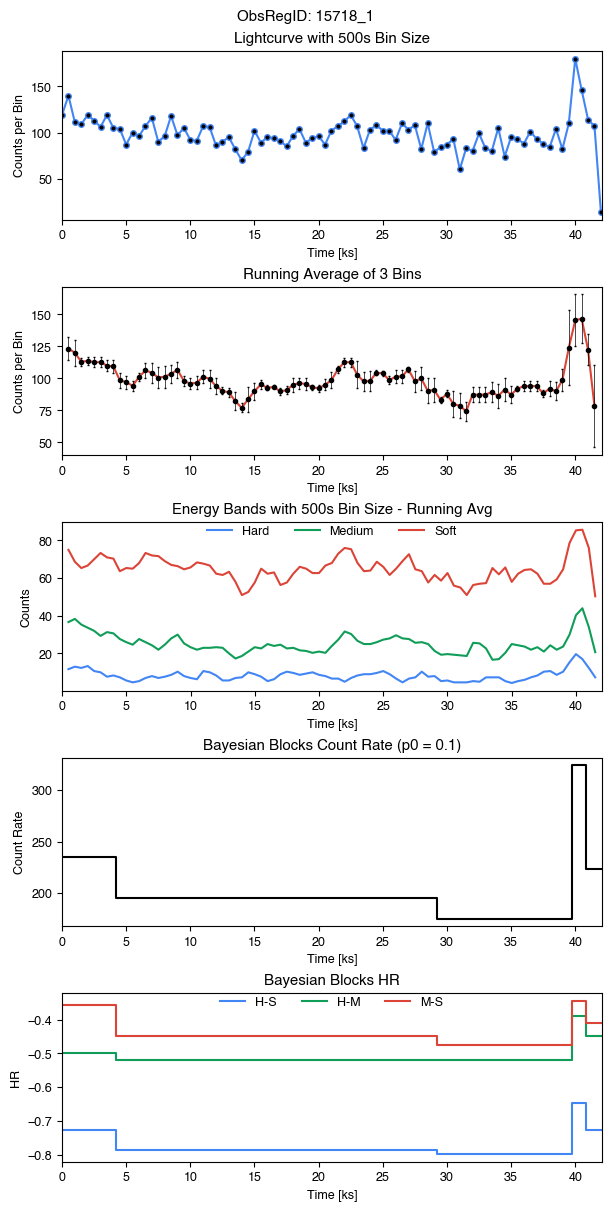

Name: 2CXO J053816.3-692331, ID: 16446-1174, Date: 2015-06-02T12:07:10, Counts: 4130
RA  84.56780201337017 DEC  -69.39209833315289
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


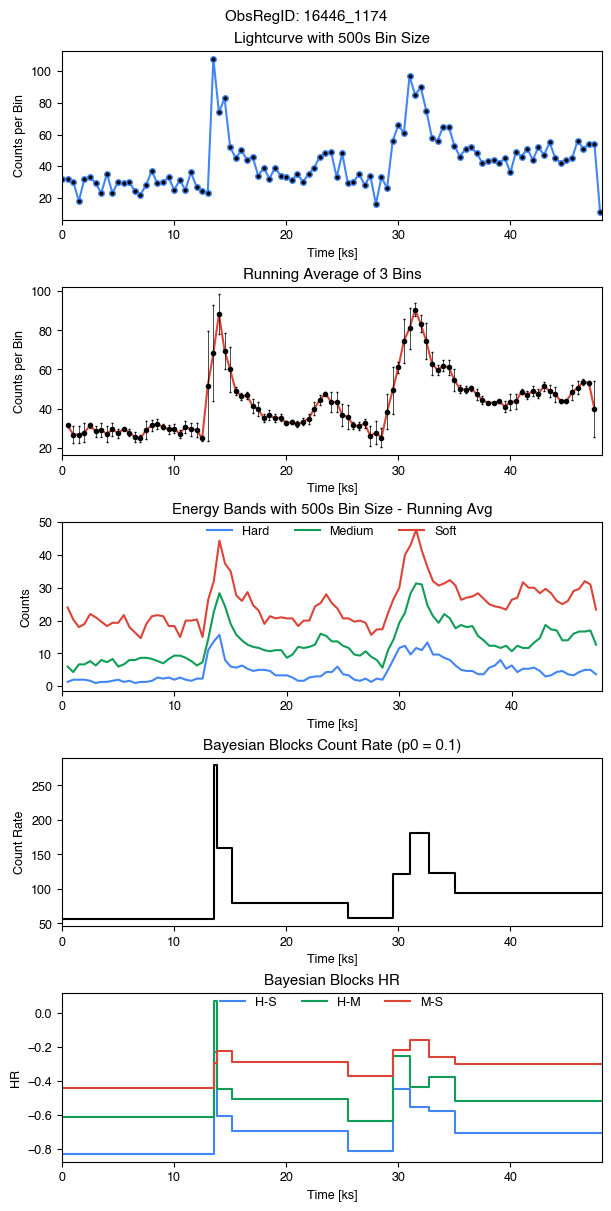

Name: 2CXO J002400.9-720453, ID: 16528-14, Date: 2015-02-02T14:37:57, Counts: 2618
RA  6.003964143630071 DEC  -72.08148344719679
varB  1.0 varH  0.34 varM  1.0 varS  1.0 varINDEX  10.0


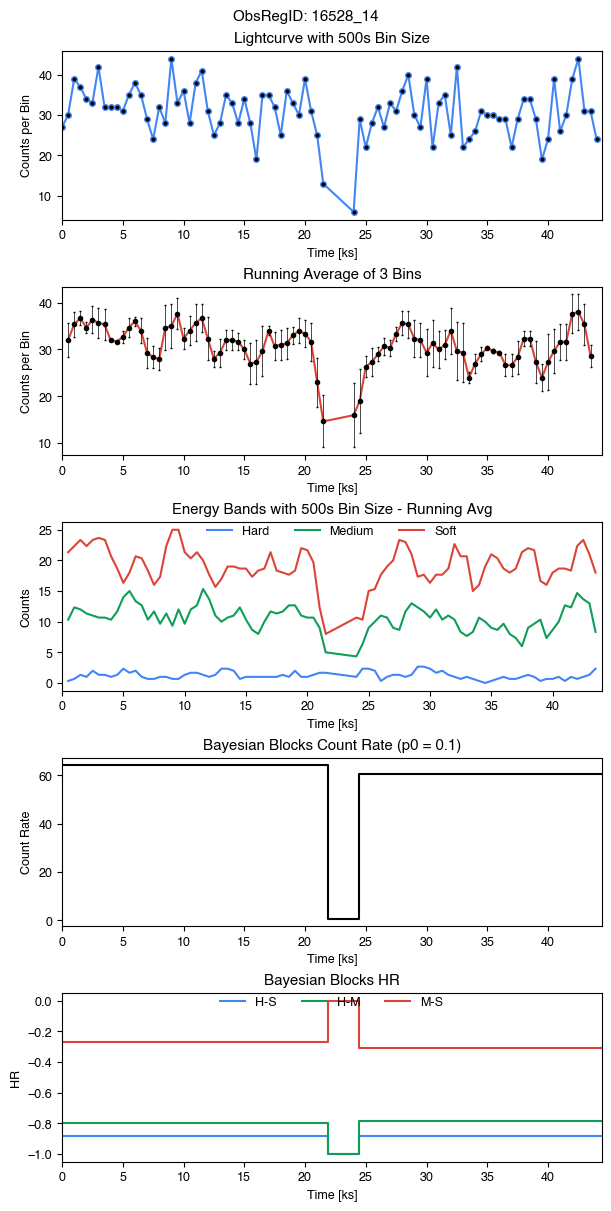

Name: 2CXO J041739.8-624627, ID: 16745-40, Date: 2016-06-09T15:27:47, Counts: 398
RA  64.41613314184383 DEC  -62.77417947048756
varB  1.0 varH  0.34 varM  0.98 varS  0.62 varINDEX  8.0


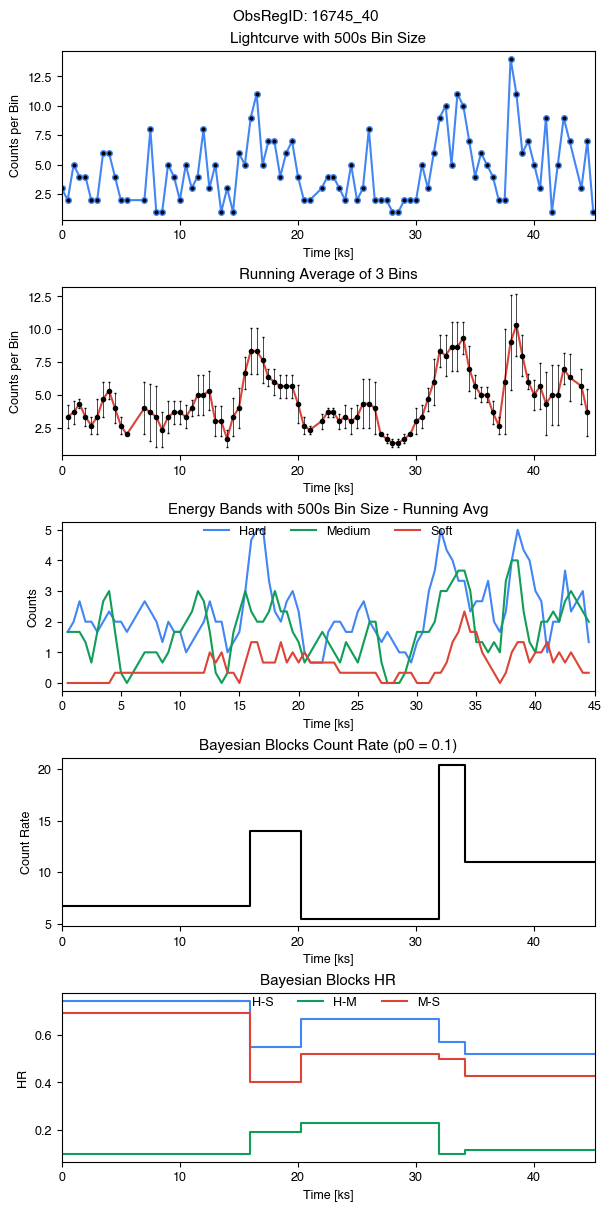

Name: 2CXO J004627.0+420152, ID: 17013-25, Date: 2015-10-17T19:59:43, Counts: 4094
RA  11.612616165184136 DEC  42.031228736623646
varB  0.91 varH  1.0 varM  0.04 varS  0.05 varINDEX  6.0


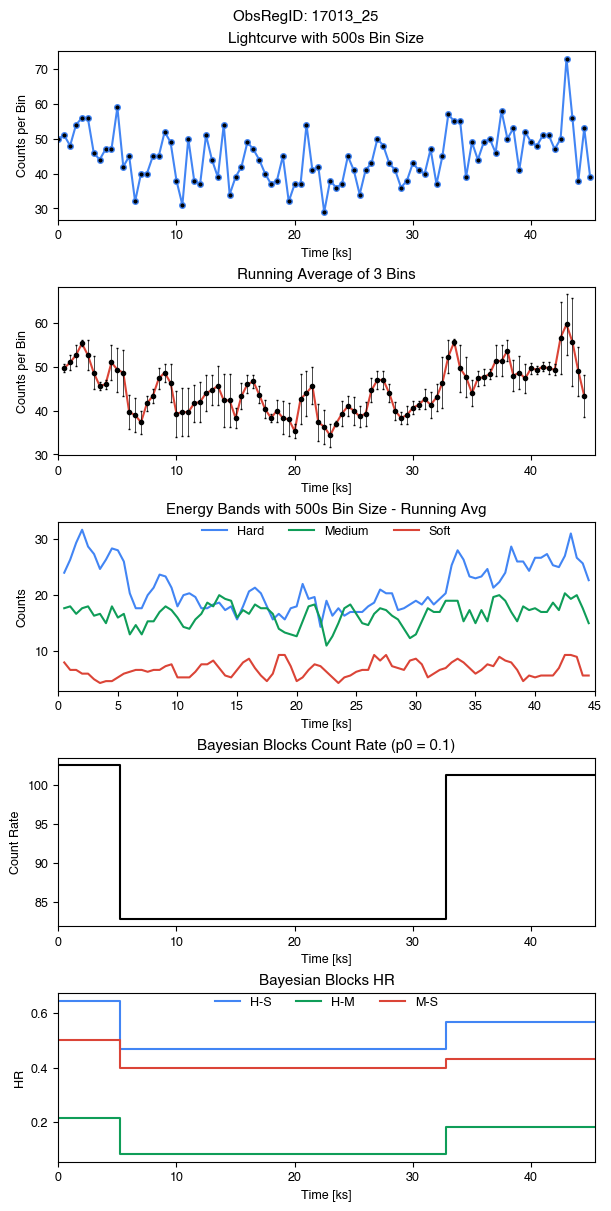

Name: 2CXO J003701.9-011911, ID: 17128-113, Date: 2015-09-04T12:41:16, Counts: 988
RA  9.258013318849464 DEC  -1.3199309070060072
varB  1.0 varH  0.76 varM  0.98 varS  0.91 varINDEX  8.0


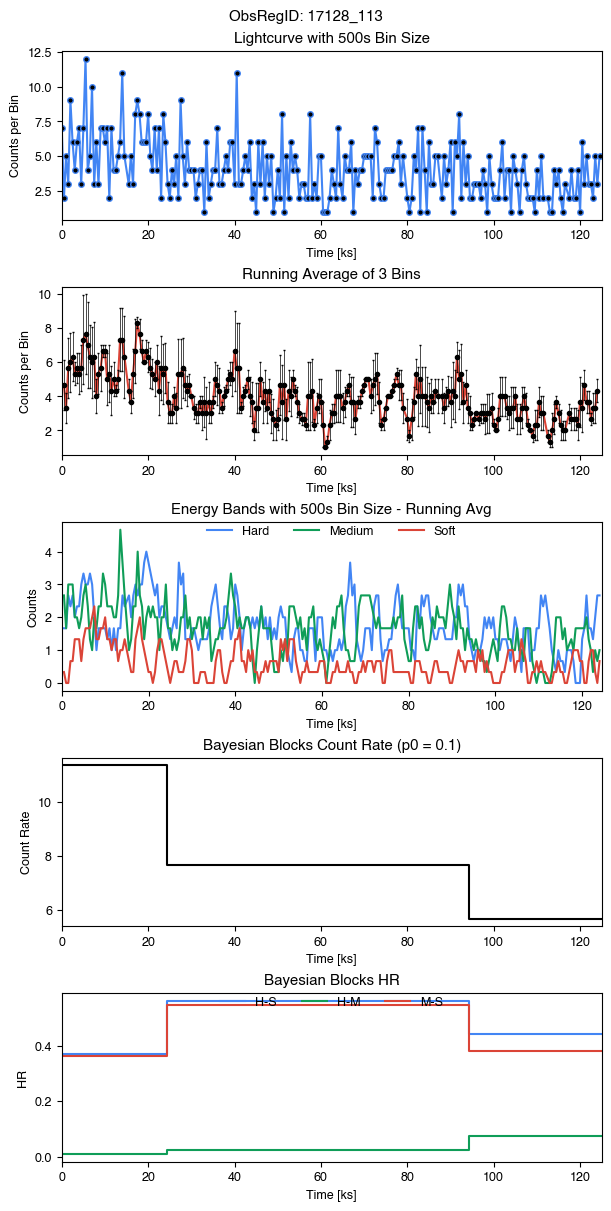

Name: 2CXO J034632.1+235858, ID: 17250-178, Date: 2015-03-27T06:14:50, Counts: 667
RA  56.6340154630563 DEC  23.9827460829443
varB  1.0 varH  0.68 varM  0.07 varS  0.07 varINDEX  8.0


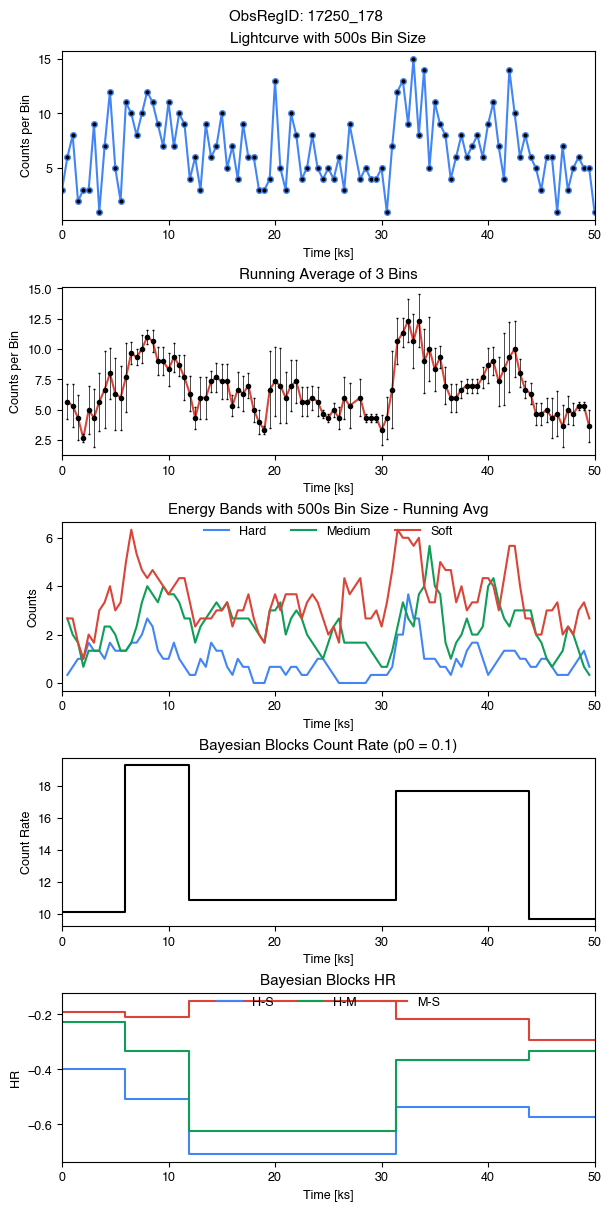

Name: 2CXO J034632.1+235858, ID: 17251-178, Date: 2015-03-30T19:37:02, Counts: 528
RA  56.6340154630563 DEC  23.9827460829443
varB  0.76 varH  0.79 varM  0.1 varS  0.52 varINDEX  5.0


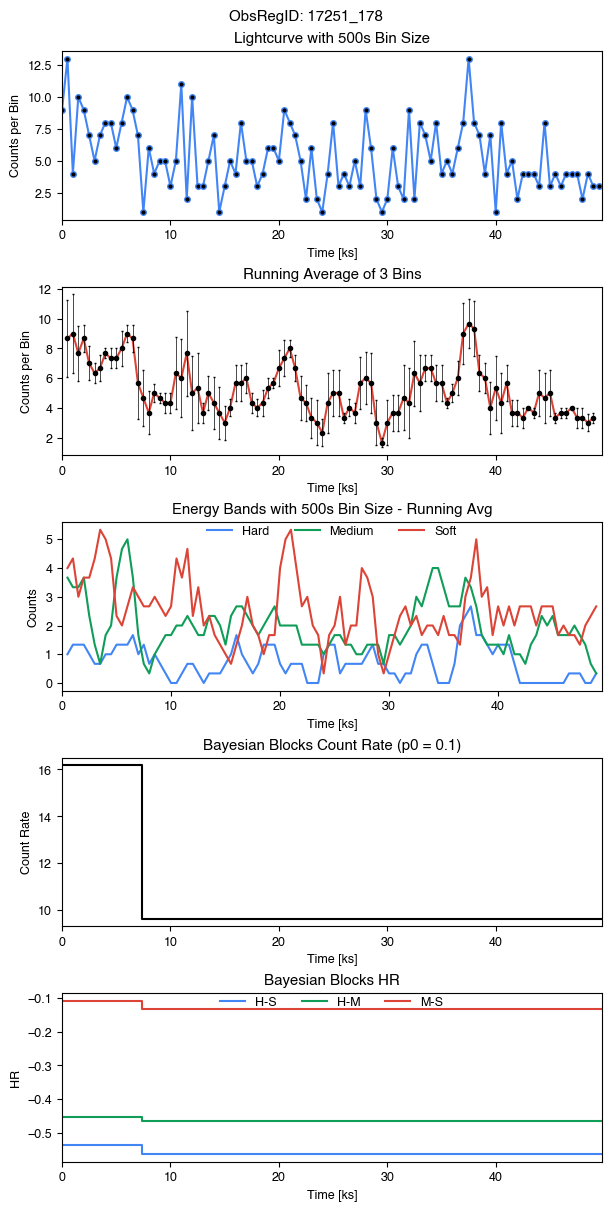

Name: 2CXO J034632.1+235858, ID: 17252-178, Date: 2015-04-02T09:12:25, Counts: 1035
RA  56.6340154630563 DEC  23.9827460829443
varB  1.0 varH  0.09 varM  1.0 varS  1.0 varINDEX  9.0


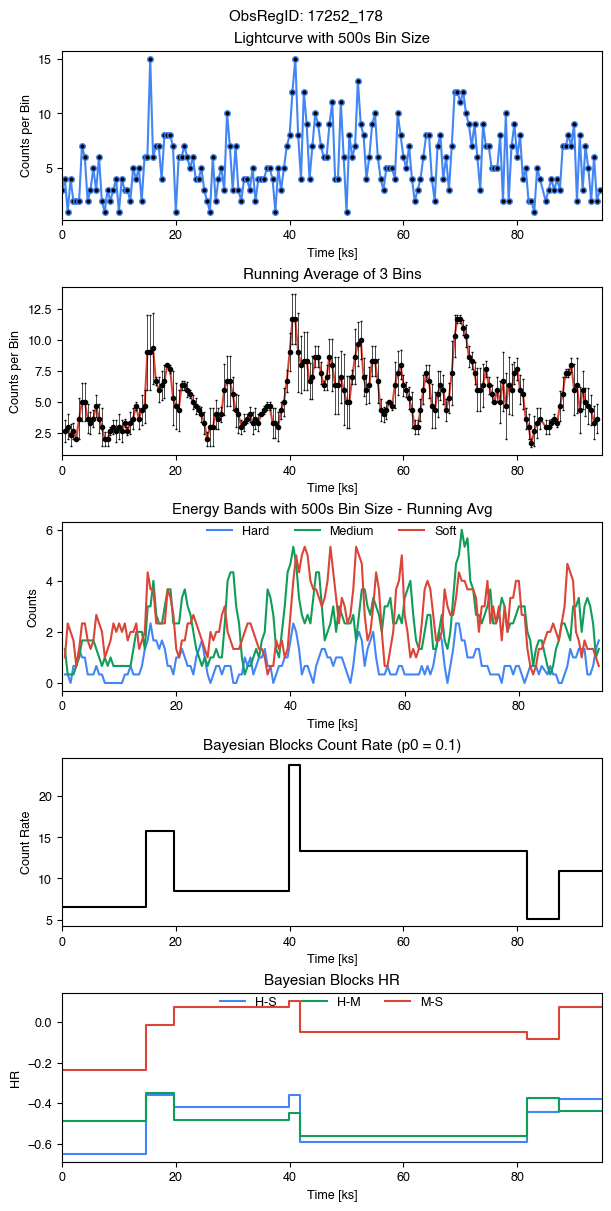

Name: 2CXO J034703.5+240934, ID: 17252-189, Date: 2015-04-02T09:12:25, Counts: 578
RA  56.76503437783799 DEC  24.15963044351324
varB  1.0 varH  0.9 varM  0.97 varS  0.63 varINDEX  8.0


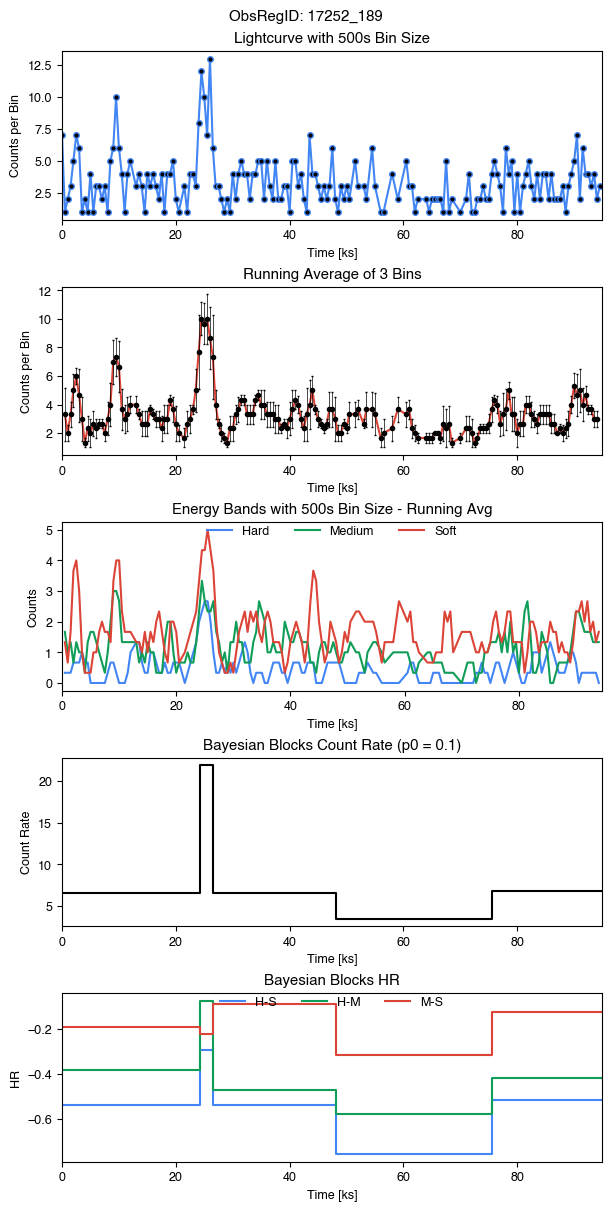

Name: 2CXO J083956.4+193310, ID: 17255-171, Date: 2015-05-17T21:30:20, Counts: 971
RA  129.98519332435848 DEC  19.552954447668515
varB  1.0 varH  1.0 varM  0.42 varS  0.05 varINDEX  8.0


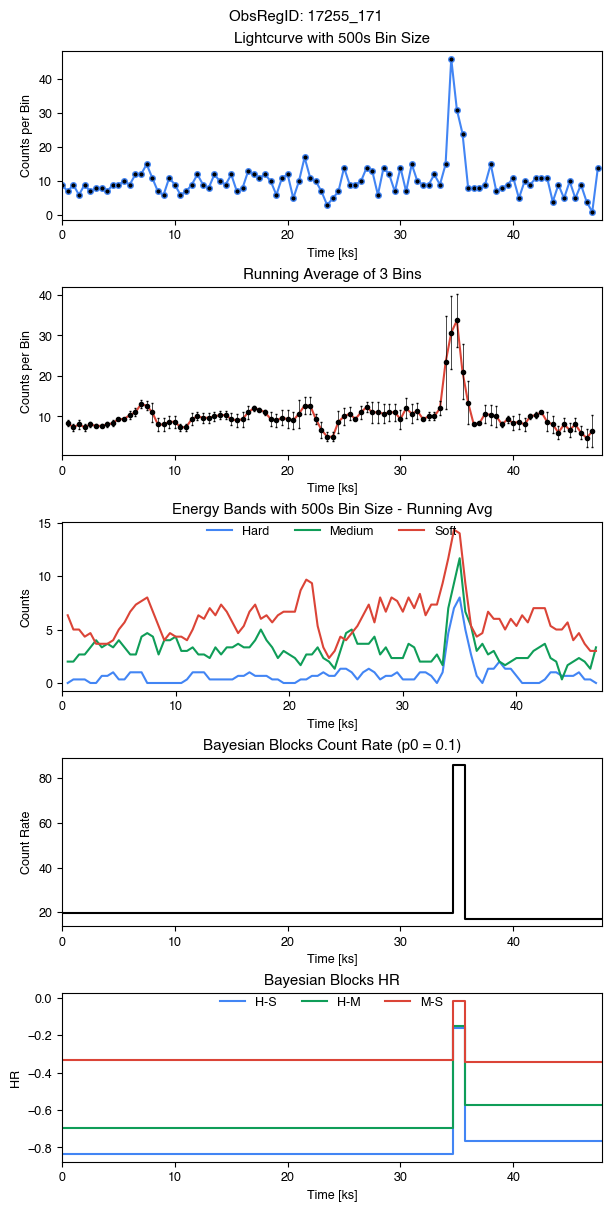

Name: 2CXO J115004.4+223519, ID: 17595-100, Date: 2015-02-18T07:34:45, Counts: 635
RA  177.51852266623905 DEC  22.588614904809056
varB  1.0 varH  0.49 varM  1.0 varS  0.89 varINDEX  8.0


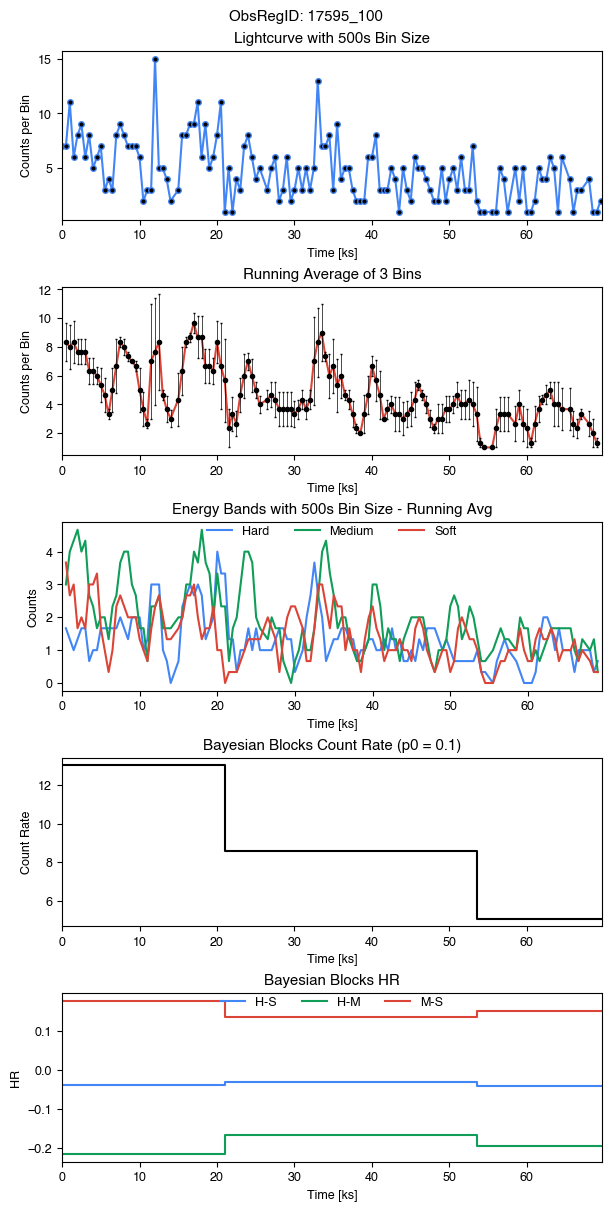

Name: 2CXO J115004.4+223519, ID: 17596-100, Date: 2015-02-10T19:01:18, Counts: 1016
RA  177.51852266623905 DEC  22.588614904809056
varB  0.95 varH  0.11 varM  0.11 varS  0.99 varINDEX  6.0


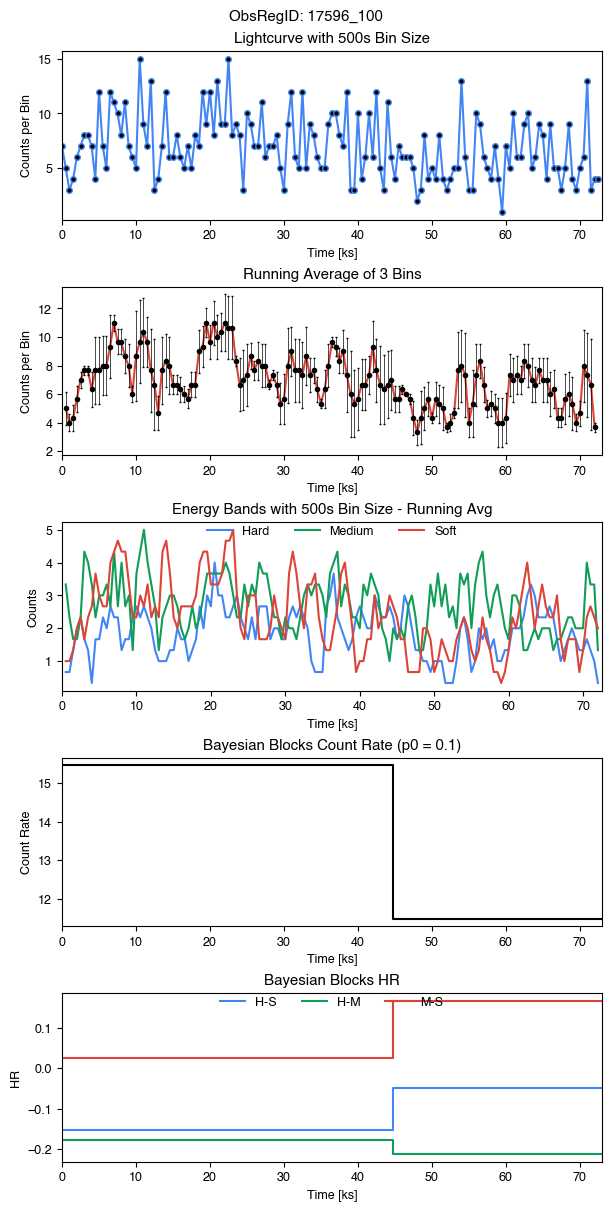

Name: 2CXO J053834.6-685306, ID: 17603-1182, Date: 2015-12-09T15:45:30, Counts: 1884
RA  84.64452641791729 DEC  -68.88515995257784
varB  1.0 varH  0.21 varM  0.99 varS  0.58 varINDEX  8.0


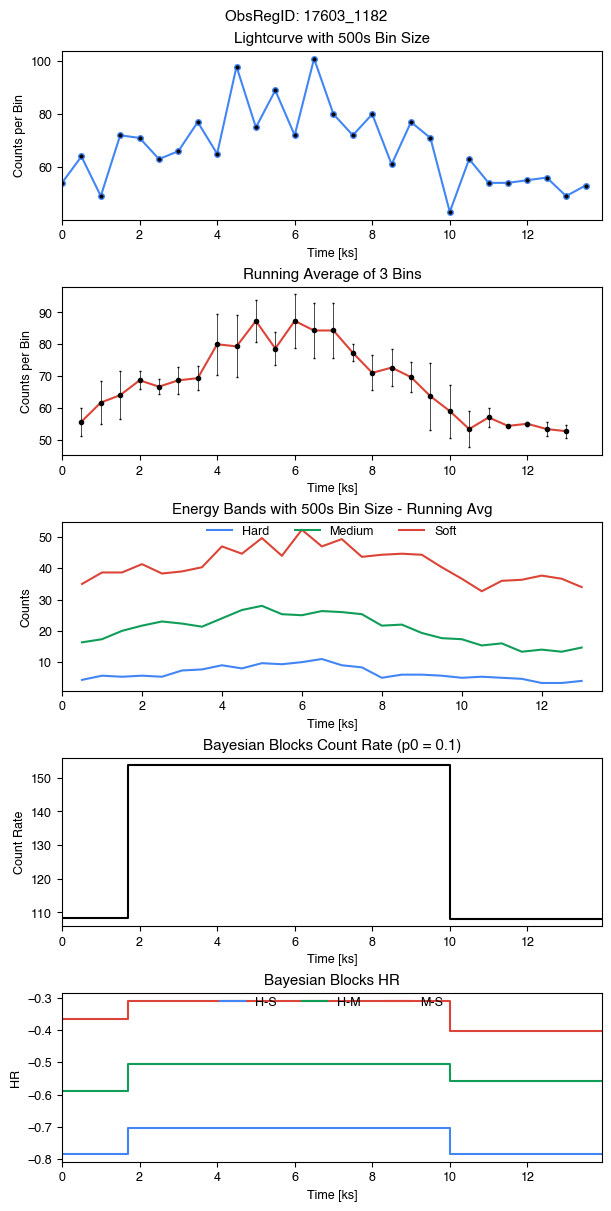

Name: 2CXO J053816.3-692331, ID: 17642-1174, Date: 2015-06-08T05:34:35, Counts: 1615
RA  84.56780201337017 DEC  -69.39209833315289
varB  0.95 varH  0.08 varM  0.75 varS  0.56 varINDEX  6.0


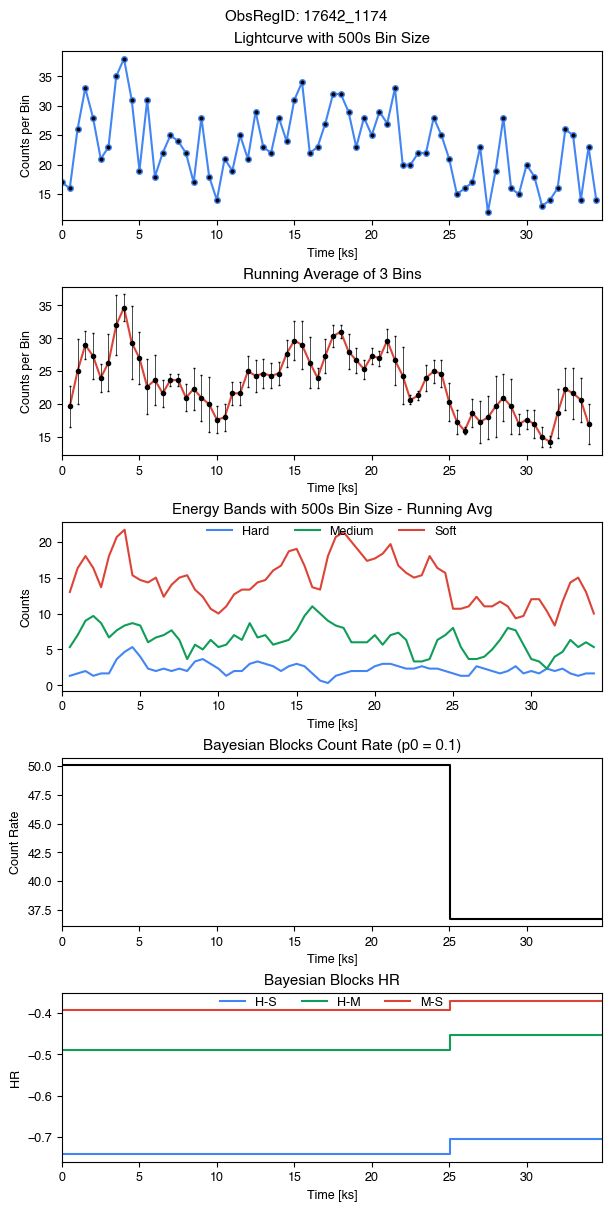

Name: 2CXO J050749.4+302404, ID: 17644-10, Date: 2015-04-16T06:56:49, Counts: 2046
RA  76.95604547242266 DEC  30.401188990787407
varB  1.0 varH  1.0 varM  1.0 varS  0.23 varINDEX  8.0


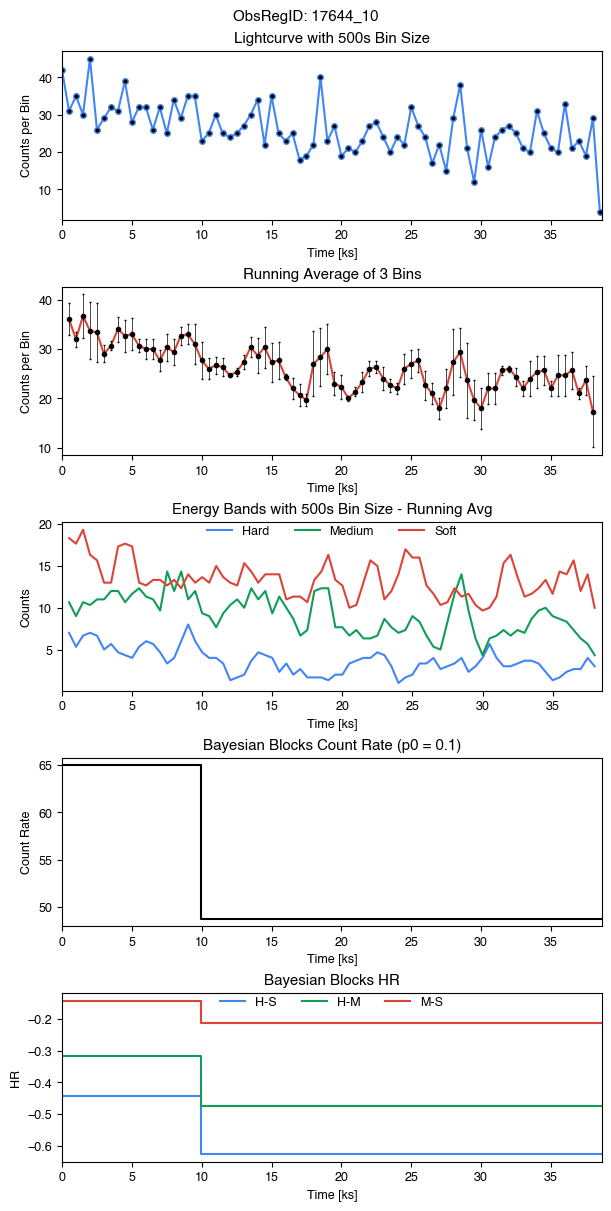

Name: 2CXO J053816.3-692331, ID: 17660-1174, Date: 2015-05-29T15:21:32, Counts: 2727
RA  84.56780201337017 DEC  -69.39209833315289
varB  1.0 varH  1.0 varM  1.0 varS  0.05 varINDEX  9.0


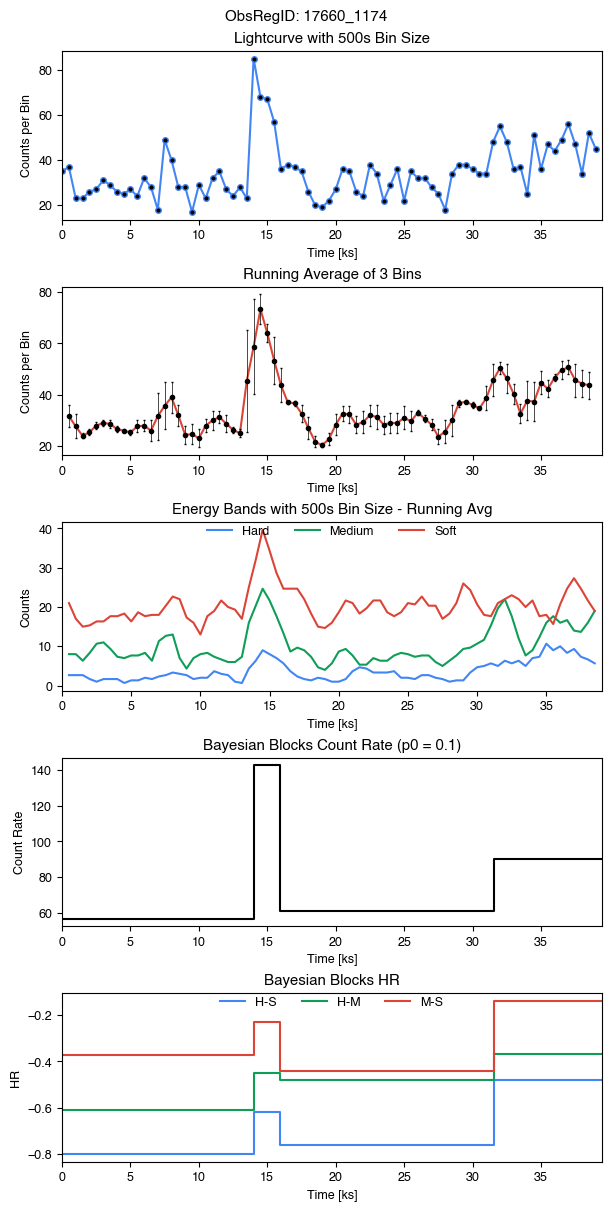

Name: 2CXO J060927.9+223628, ID: 17725-8, Date: 2016-01-12T13:25:48, Counts: 2624
RA  92.36642830210428 DEC  22.60793722222159
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


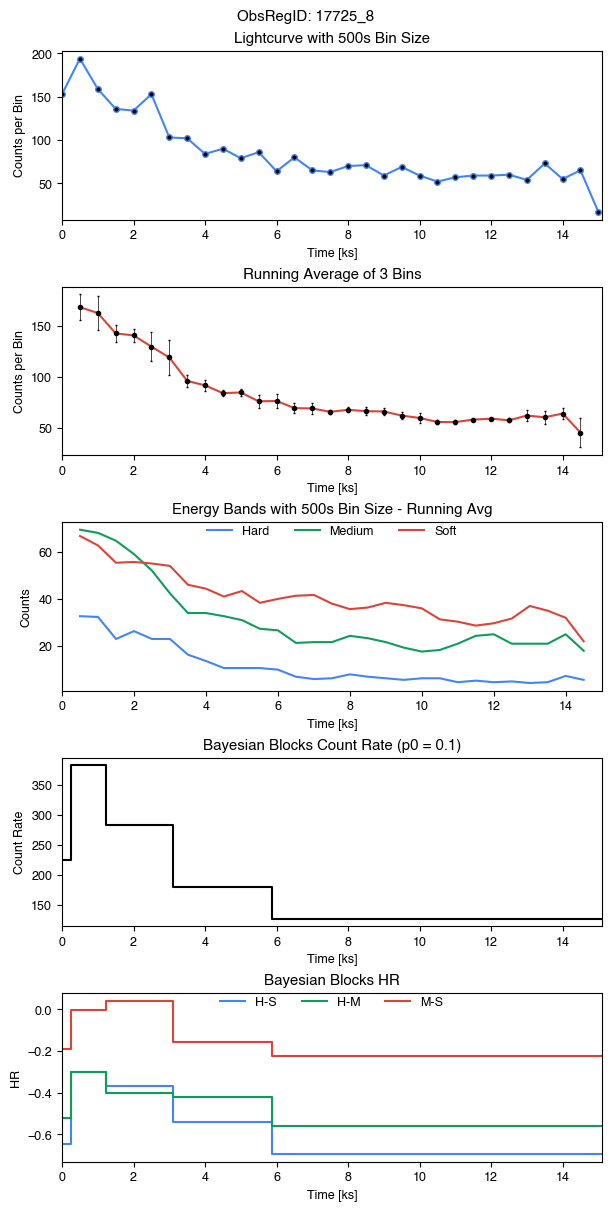

Name: 2CXO J061255.8+175907, ID: 17747-109, Date: 2017-04-25T18:03:59, Counts: 565
RA  93.23252707263634 DEC  17.98535391280163
varB  1.0 varH  0.59 varM  0.91 varS  0.35 varINDEX  7.0


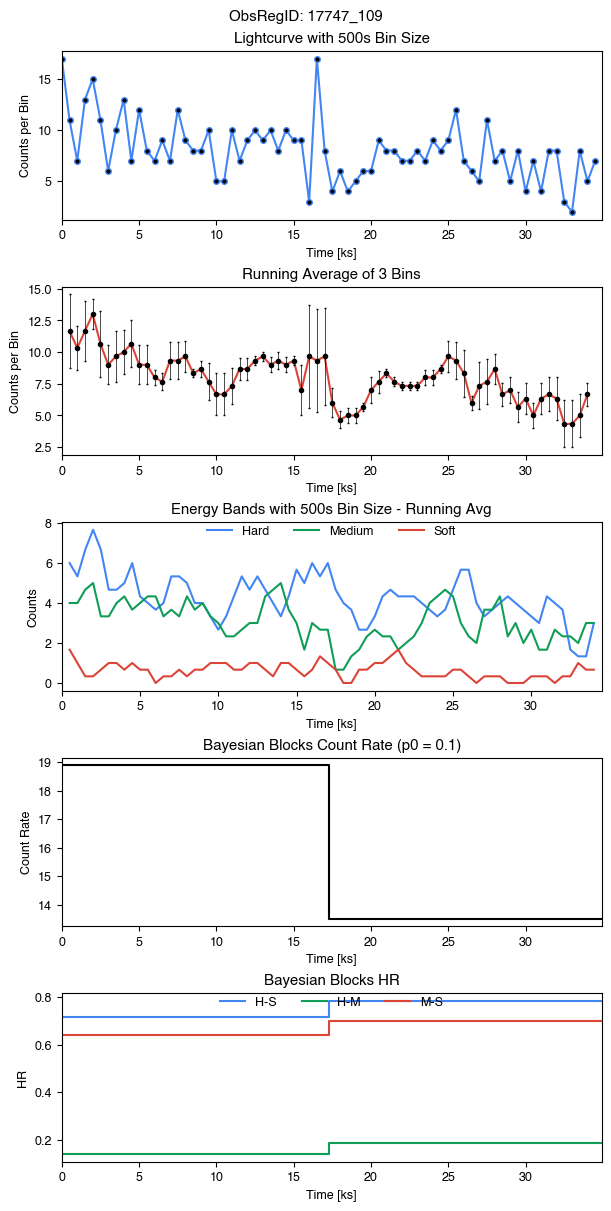

Name: 2CXO J013923.9+292406, ID: 18142-3, Date: 2015-11-25T12:31:40, Counts: 1888
RA  24.849974154052063 DEC  29.40189999140512
varB  0.74 varH  0.15 varM  0.29 varS  0.11 varINDEX  5.0


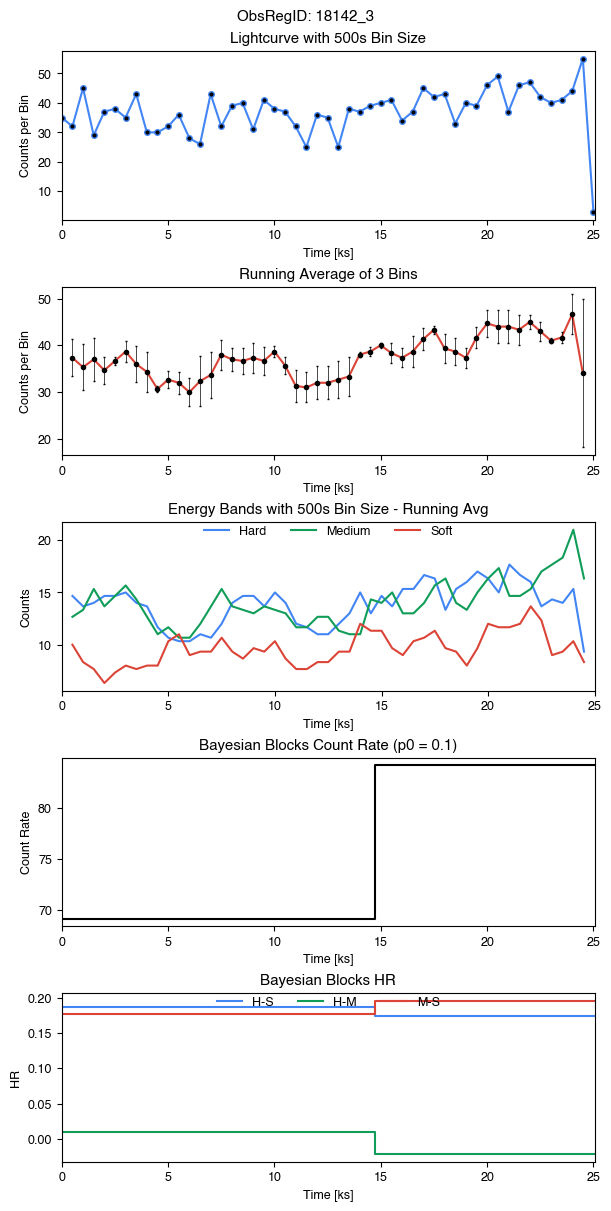

Name: 2CXO J073030.8+410110, ID: 18184-117, Date: 2016-12-11T17:17:16, Counts: 668
RA  112.62867523240556 DEC  41.019600348729696
varB  1.0 varH  0.3 varM  1.0 varS  1.0 varINDEX  9.0


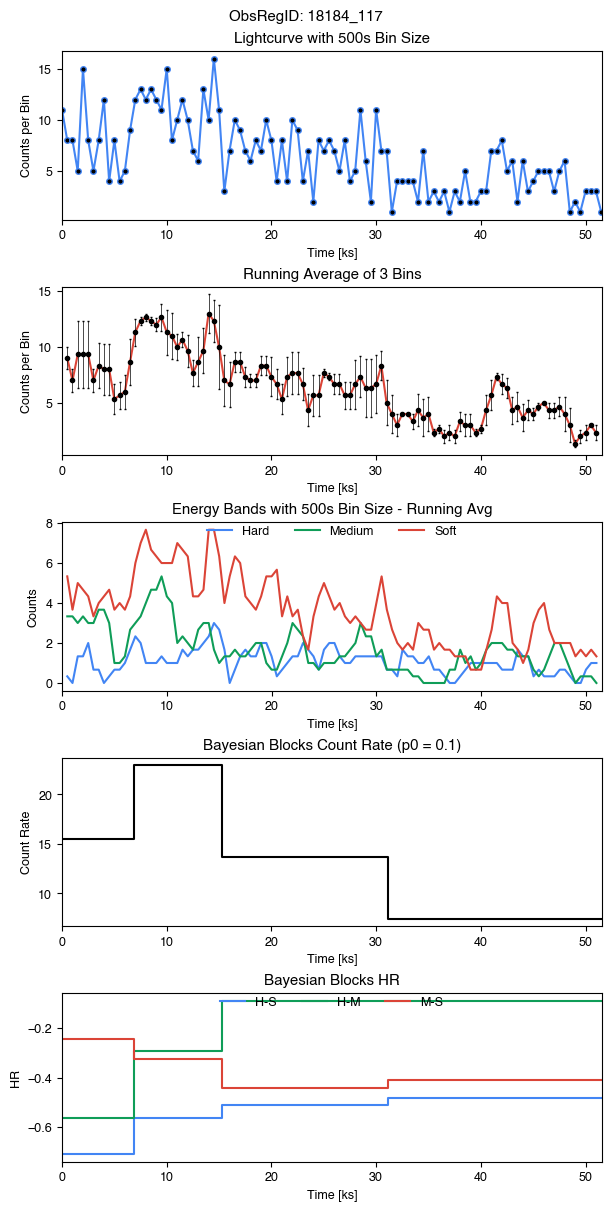

Name: 2CXO J053834.6-685306, ID: 18671-1182, Date: 2015-12-14T00:11:19, Counts: 30163
RA  84.64452641791729 DEC  -68.88515995257784
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


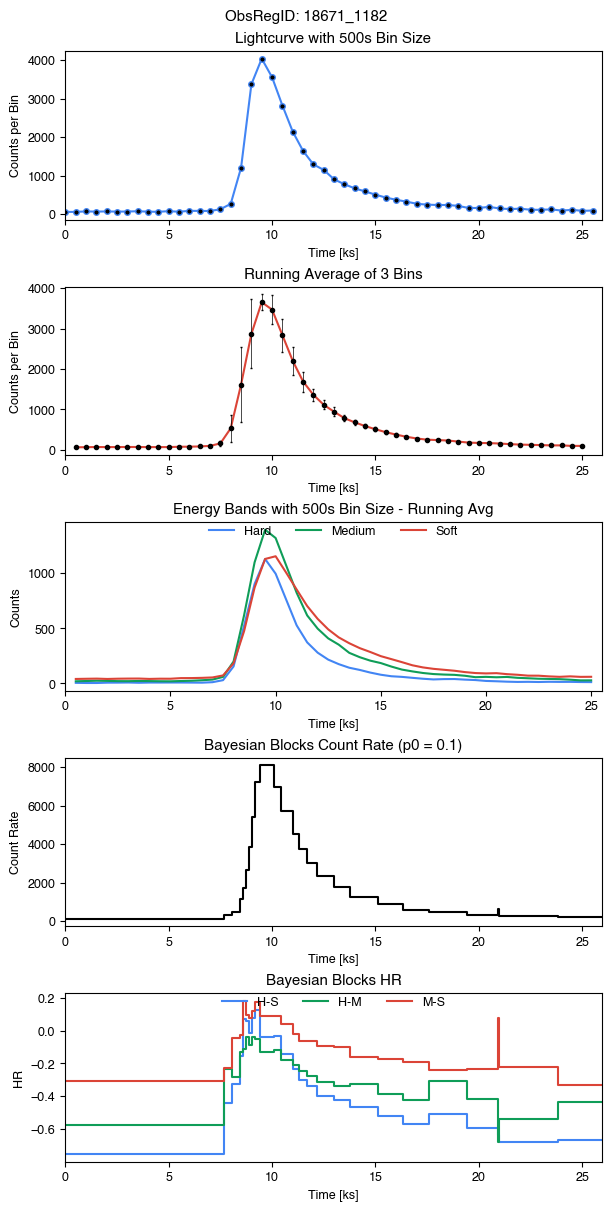

Name: 2CXO J053834.6-685306, ID: 18672-1182, Date: 2015-11-08T01:25:03, Counts: 2262
RA  84.64452641791729 DEC  -68.88515995257784
varB  1.0 varH  0.96 varM  0.99 varS  0.04 varINDEX  8.0


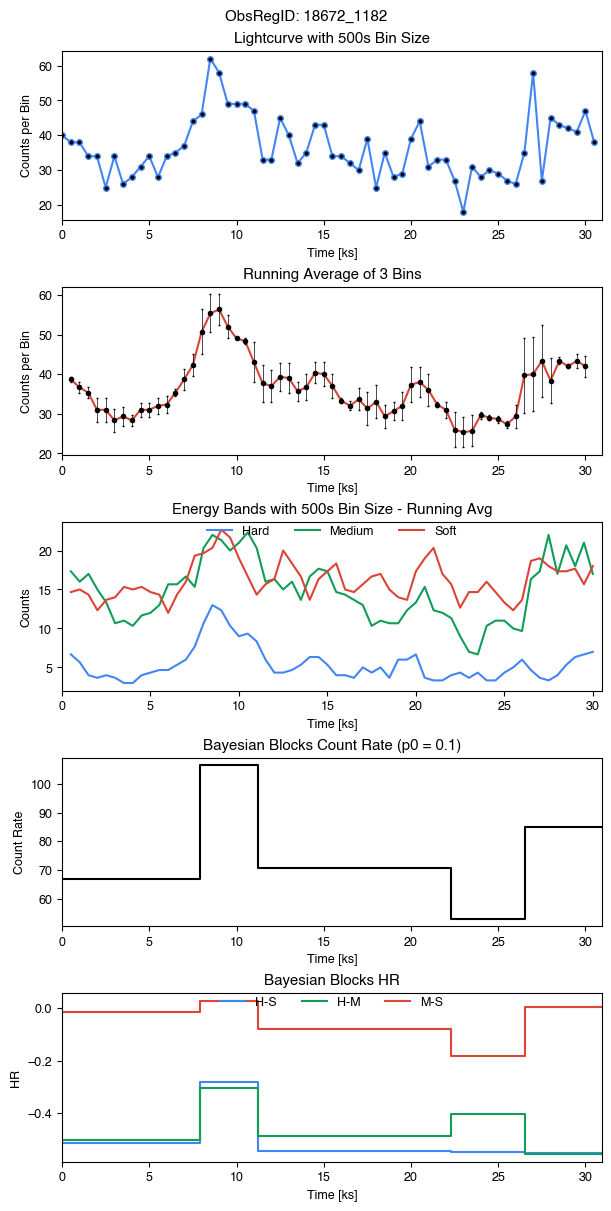

Name: 2CXO J053834.6-685306, ID: 18722-1182, Date: 2015-12-11T09:36:18, Counts: 1960
RA  84.64452641791729 DEC  -68.88515995257784
varB  1.0 varH  0.9 varM  0.42 varS  0.47 varINDEX  7.0


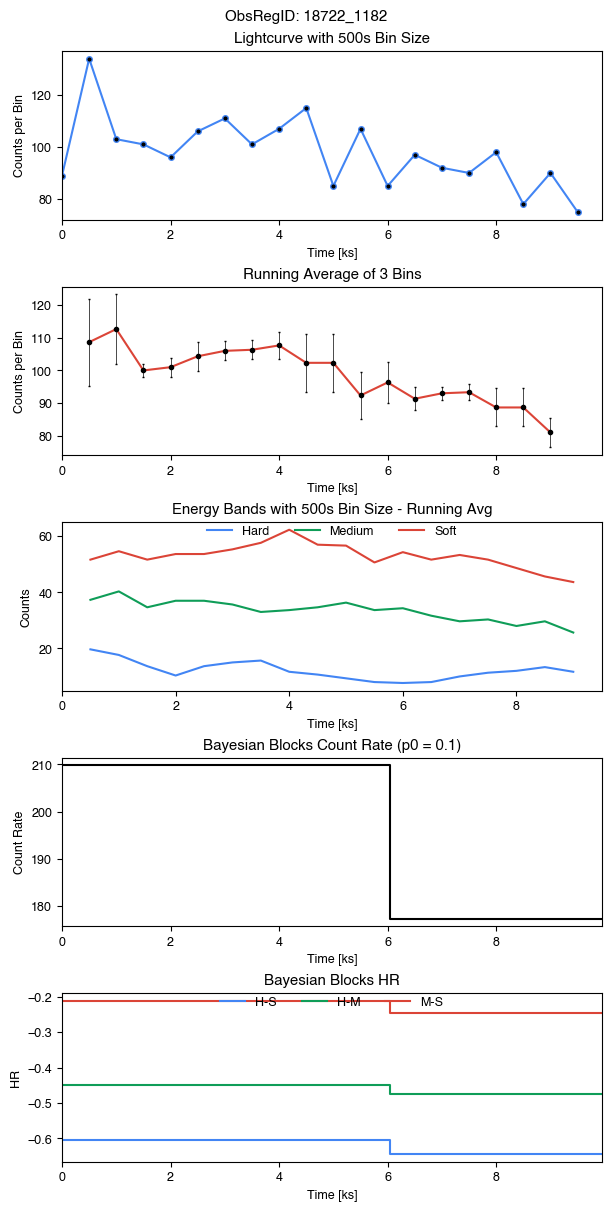

Name: 2CXO J053834.6-685306, ID: 18729-1182, Date: 2015-12-21T22:36:50, Counts: 2747
RA  84.64452641791729 DEC  -68.88515995257784
varB  1.0 varH  0.98 varM  0.98 varS  0.51 varINDEX  8.0


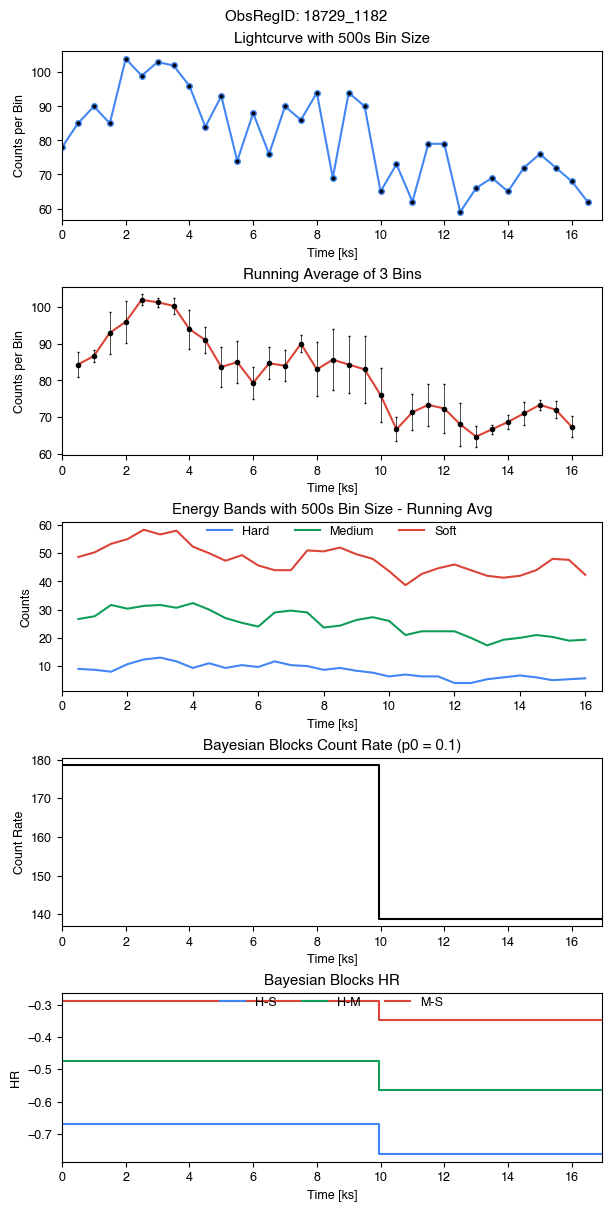

Name: 2CXO J053809.9-685657, ID: 18750-224, Date: 2016-01-20T01:11:37, Counts: 467
RA  84.54126081118812 DEC  -68.94937468296398
varB  1.0 varH  0.88 varM  0.98 varS  0.39 varINDEX  8.0


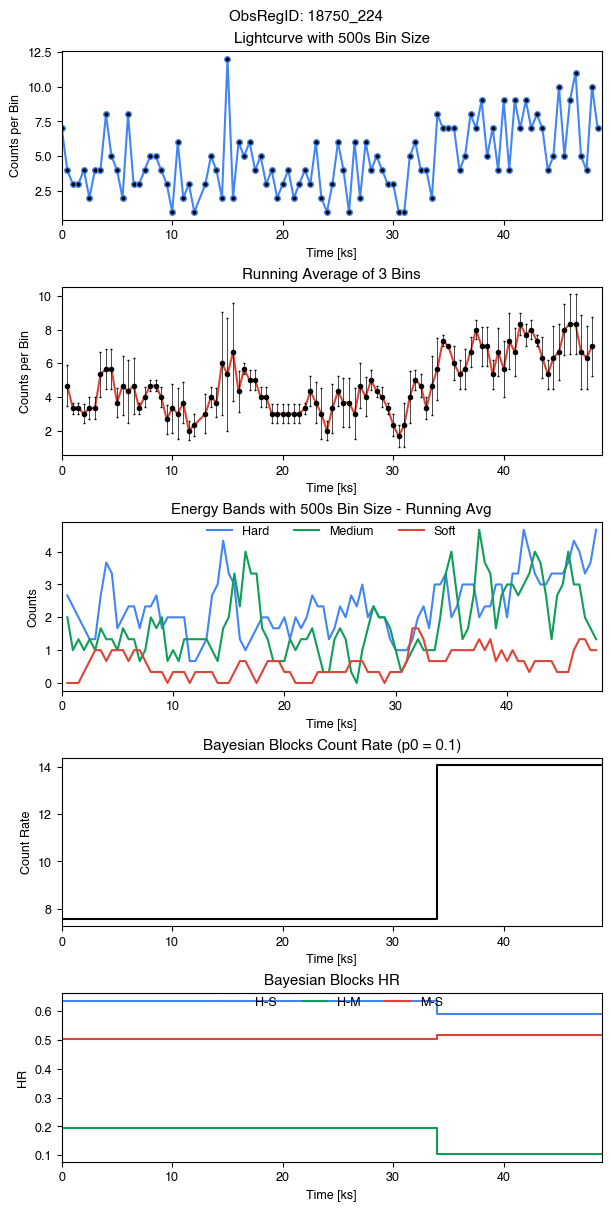

Name: 2CXO J052452.2+013844, ID: 18926-96, Date: 2017-01-14T08:17:40, Counts: 756
RA  81.21780081218833 DEC  1.6455459763996083
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  9.0


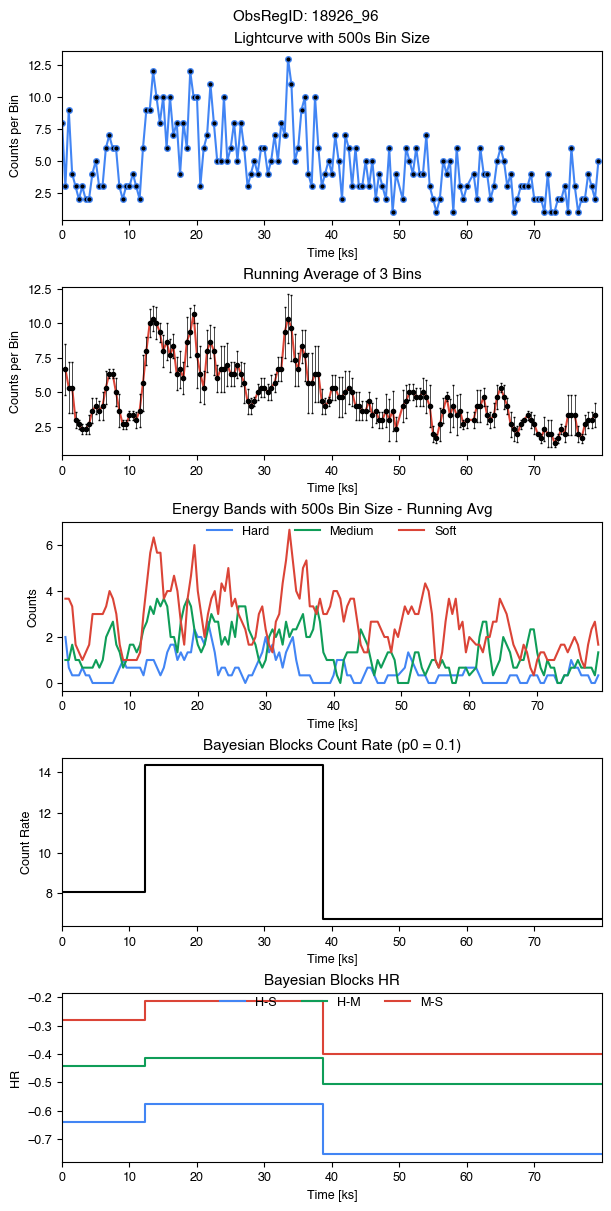

Name: 2CXO J052454.9+013924, ID: 18926-97, Date: 2017-01-14T08:17:40, Counts: 2917
RA  81.22918742511342 DEC  1.6564157229879222
varB  1.0 varH  0.31 varM  1.0 varS  0.7 varINDEX  8.0


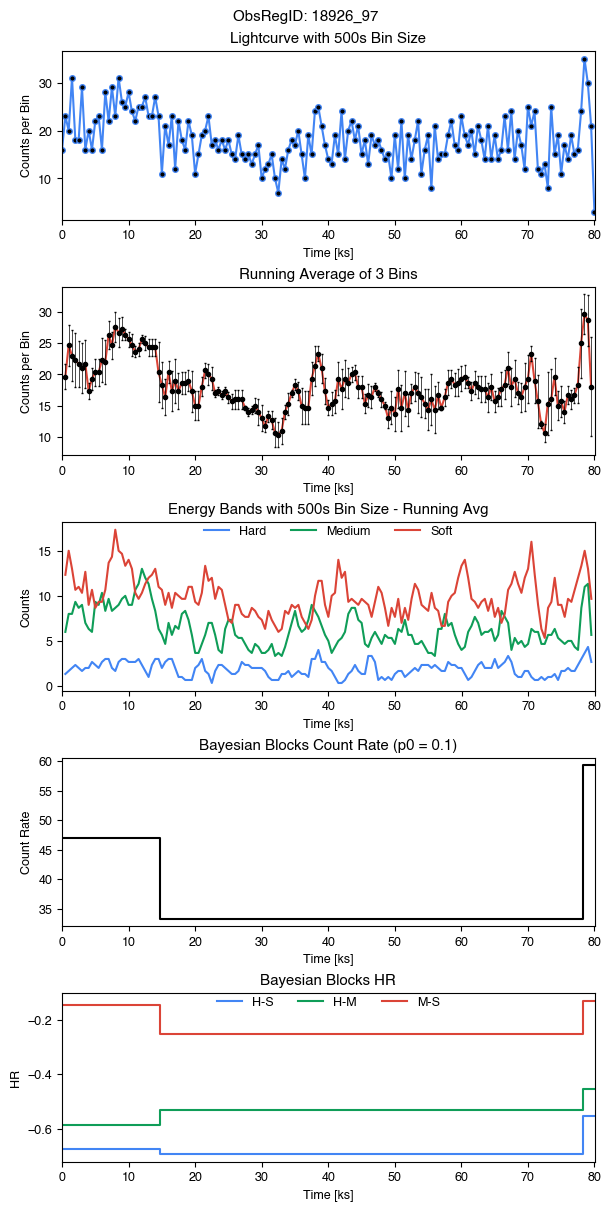

Name: 2CXO J052539.7+012546, ID: 18926-99, Date: 2017-01-14T08:17:40, Counts: 758
RA  81.41552142207445 DEC  1.4296347194432726
varB  1.0 varH  0.98 varM  1.0 varS  0.99 varINDEX  9.0


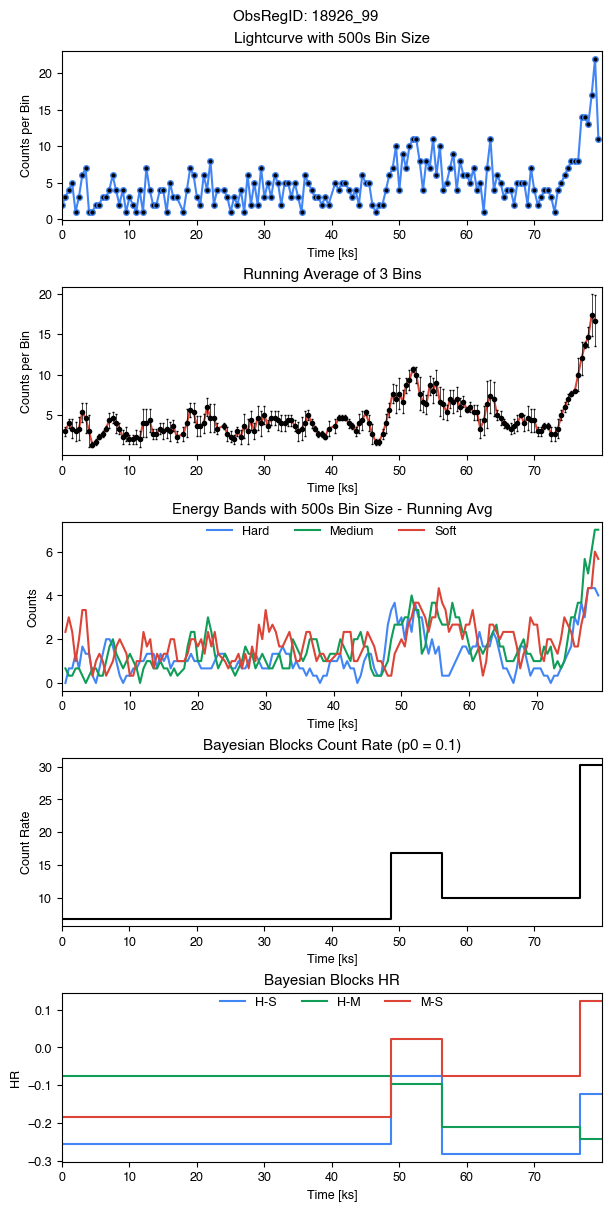

Name: 2CXO J053521.7-045312, ID: 18927-107, Date: 2017-12-13T04:21:20, Counts: 597
RA  83.84061215626406 DEC  -4.886689586860536
varB  1.0 varH  0.99 varM  1.0 varS  0.14 varINDEX  8.0


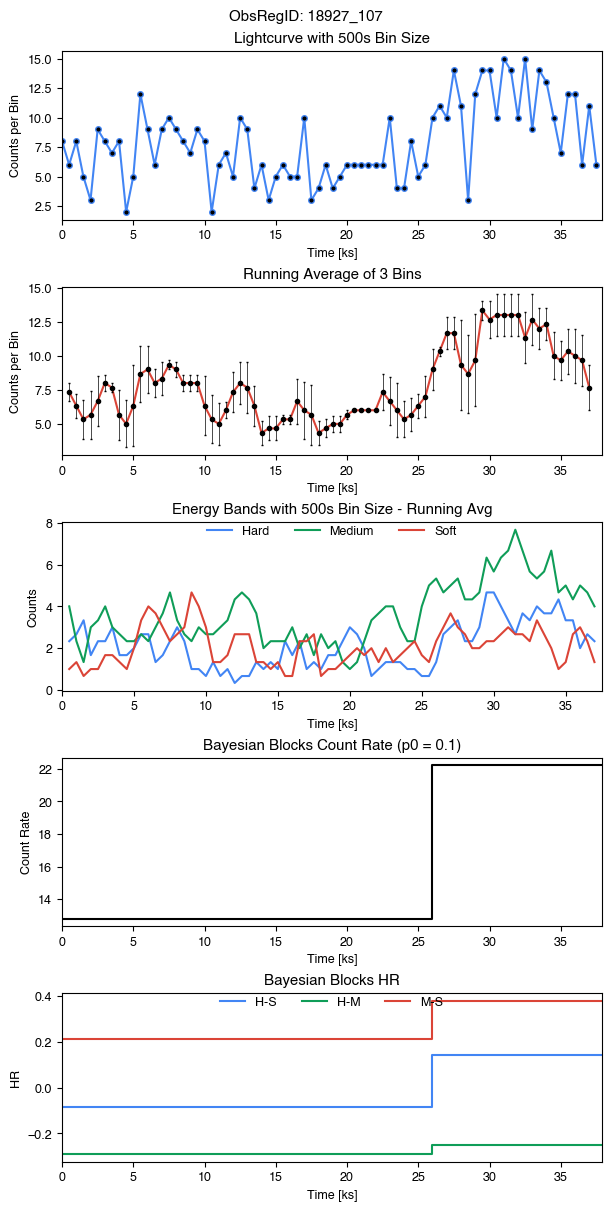

Name: 2CXO J053504.3-050812, ID: 18927-202, Date: 2017-12-13T04:21:20, Counts: 7056
RA  83.76795861245432 DEC  -5.13692855868757
varB  1.0 varH  1.0 varM  0.98 varS  0.06 varINDEX  8.0


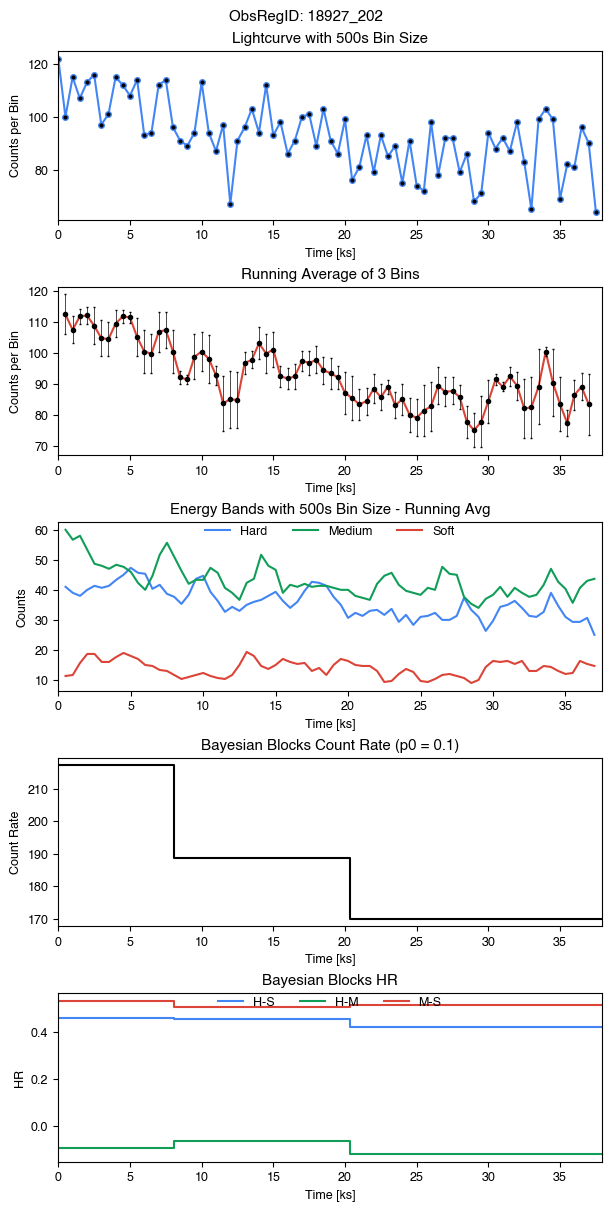

Name: 2CXO J085633.0+122554, ID: 19328-41, Date: 2017-12-30T11:58:17, Counts: 2960
RA  134.13786102294944 DEC  12.431688756747814
varB  1.0 varH  1.0 varM  0.96 varS  0.35 varINDEX  8.0


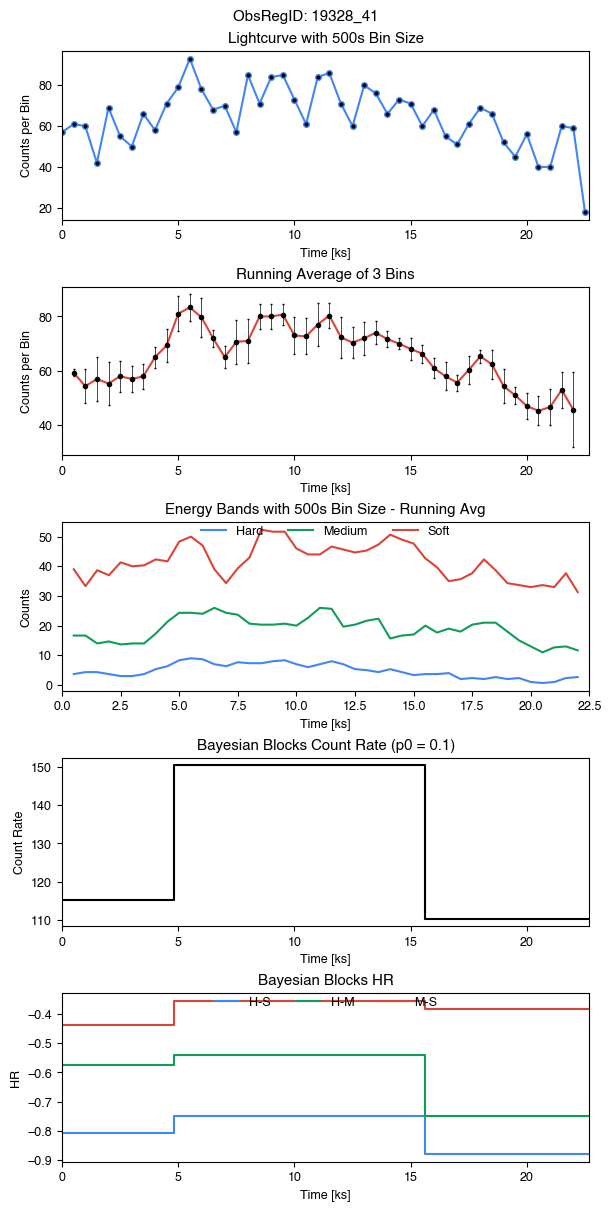

Name: 2CXO J091449.0+085321, ID: 19464-55, Date: 2018-01-12T11:24:16, Counts: 2335
RA  138.7043926343228 DEC  8.889235644759792
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


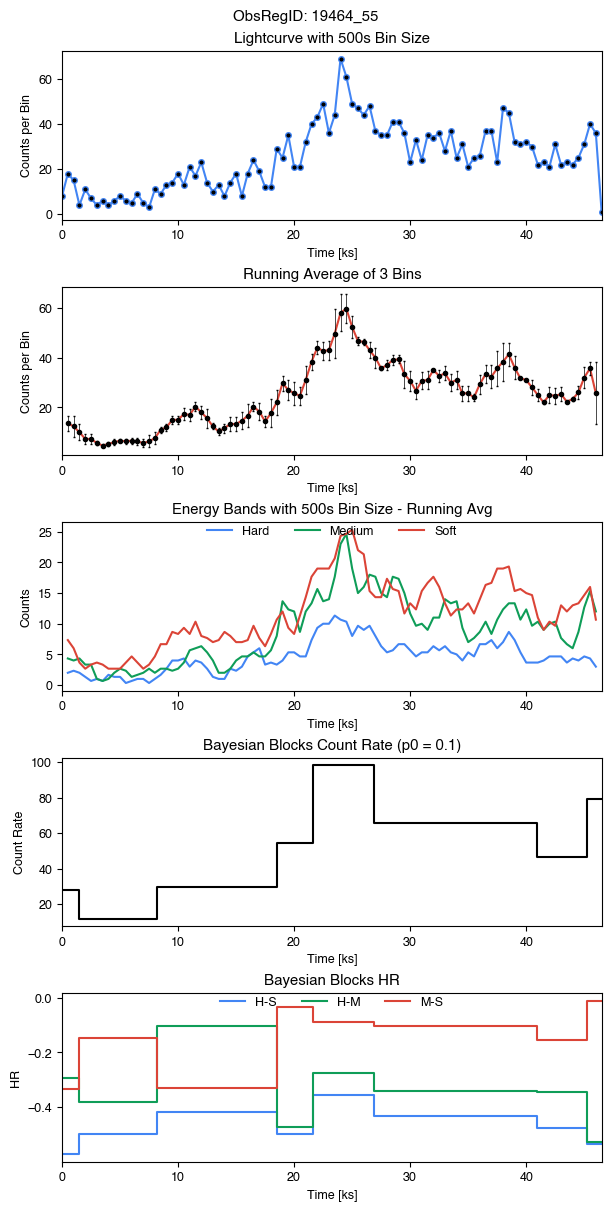

Name: 2CXO J112008.4-614104, ID: 19690-267, Date: 2016-10-27T18:38:43, Counts: 659
RA  170.03509606727232 DEC  -61.684543070449735
varB  1.0 varH  nan varM  1.0 varS  0.81 varINDEX  8.0


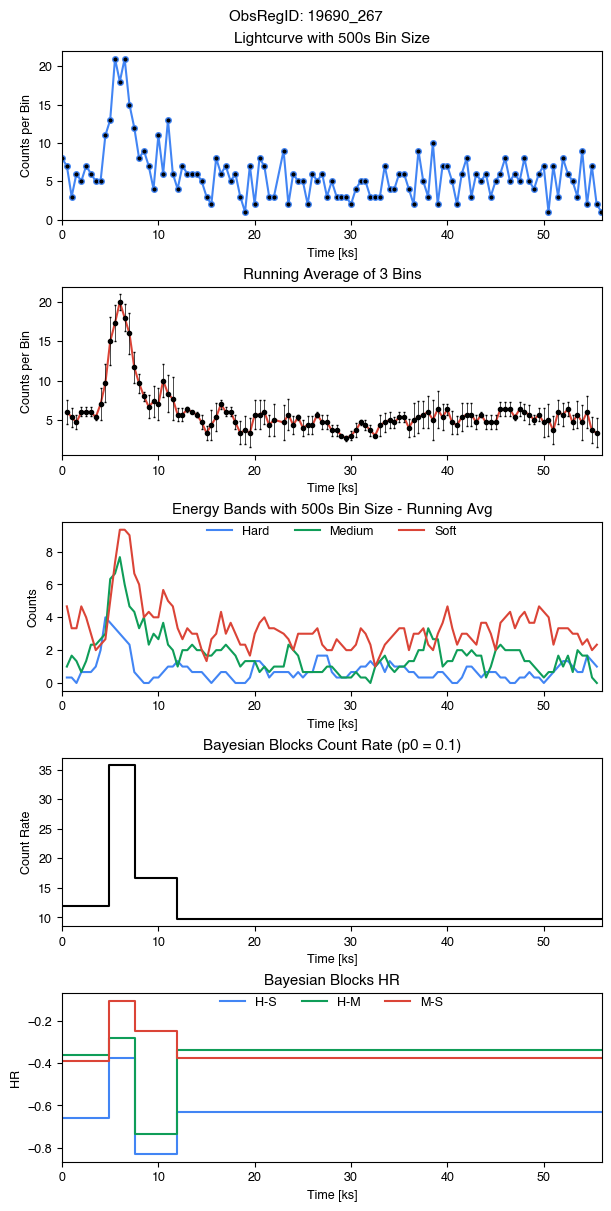

Name: 2CXO J044954.8+451129, ID: 19965-116, Date: 2016-12-21T08:03:31, Counts: 524
RA  72.47863021465355 DEC  45.192411270089806
varB  1.0 varH  0.99 varM  1.0 varS  0.57 varINDEX  8.0


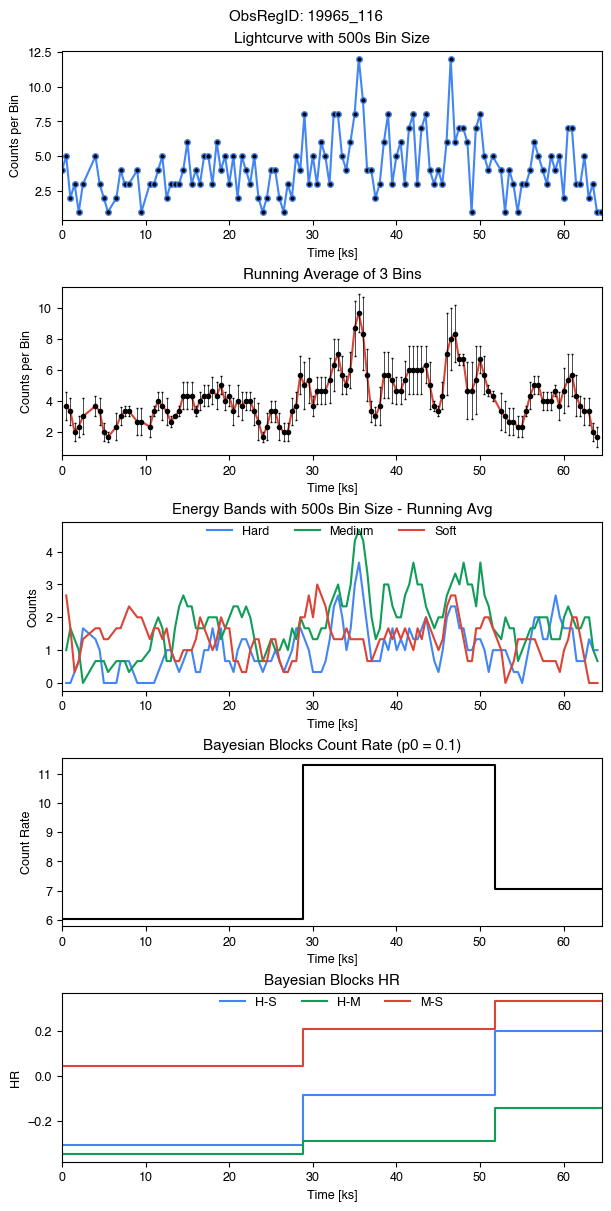

Name: 2CXO J120308.2-382656, ID: 20061-92, Date: 2017-08-30T07:45:48, Counts: 920
RA  180.78431733364823 DEC  -38.448901446400725
varB  1.0 varH  0.99 varM  1.0 varS  1.0 varINDEX  9.0


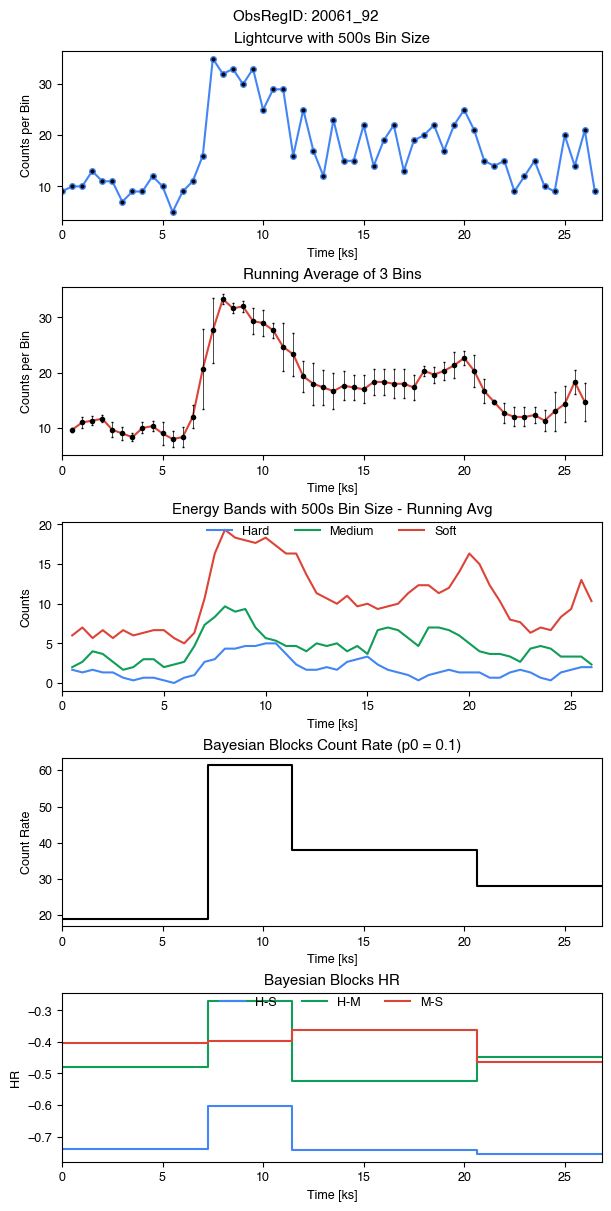

Name: 2CXO J104358.4-593308, ID: 20152-498, Date: 2018-06-19T08:55:02, Counts: 773
RA  160.99346413743683 DEC  -59.552337380598786
varB  1.0 varH  1.0 varM  0.57 varS  0.32 varINDEX  8.0


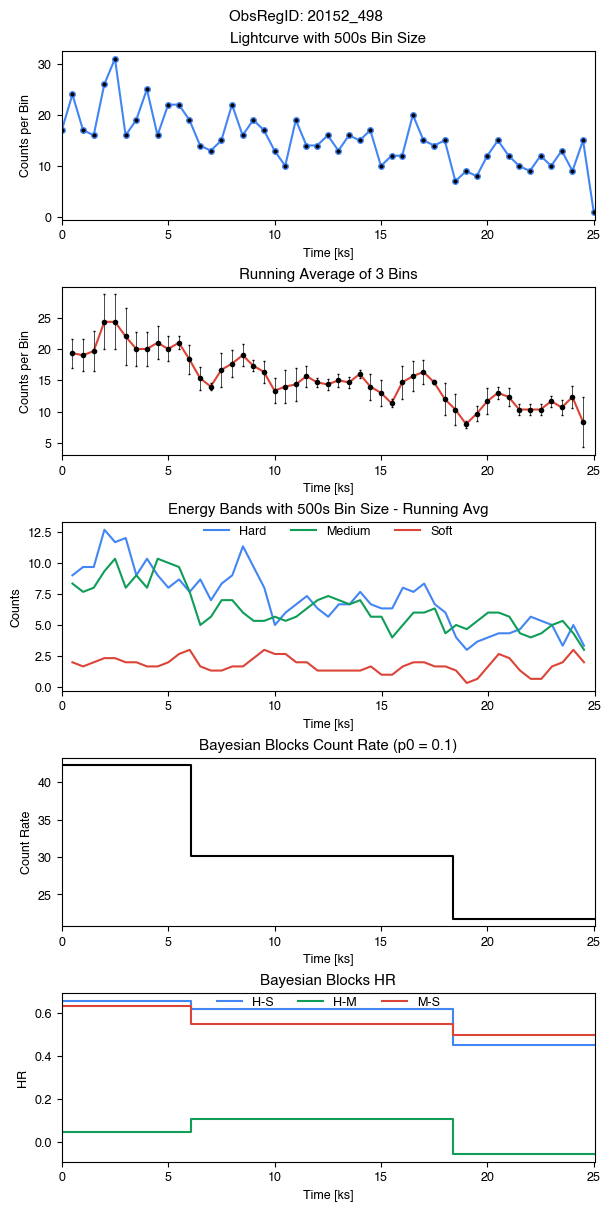

Name: 2CXO J004717.6-251826, ID: 20343-22, Date: 2018-08-15T19:35:55, Counts: 608
RA  11.82356608961345 DEC  -25.30759599271042
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


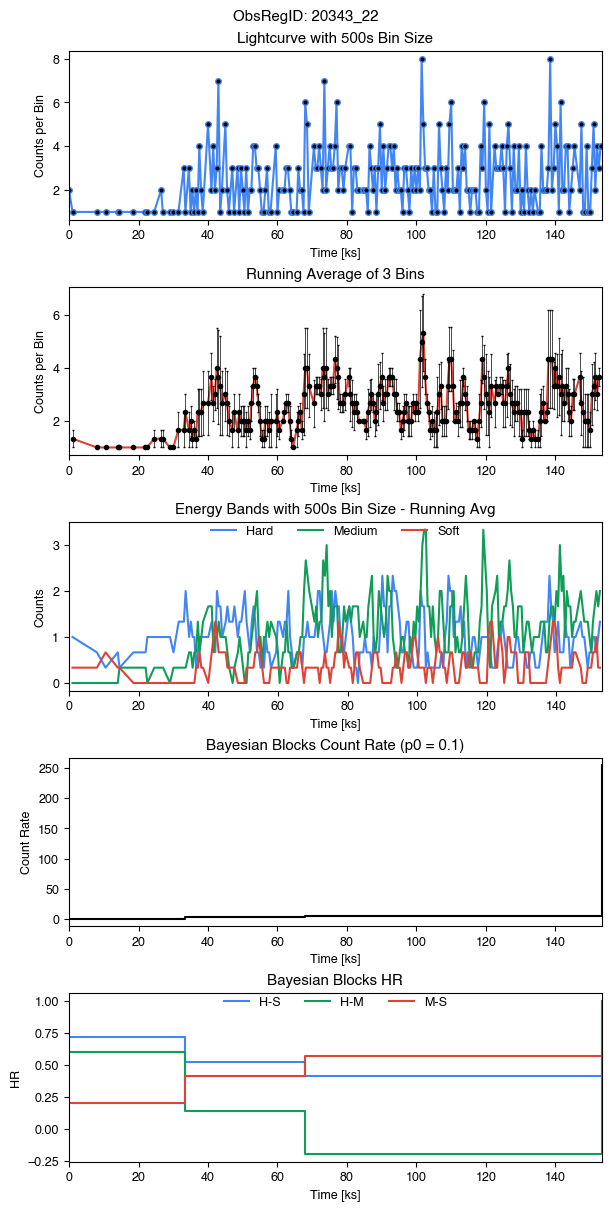

Name: 2CXO J053556.0-045655, ID: 20882-85, Date: 2017-12-14T01:39:30, Counts: 328
RA  83.98368439317335 DEC  -4.948643714127399
varB  1.0 varH  1.0 varM  1.0 varS  0.94 varINDEX  8.0


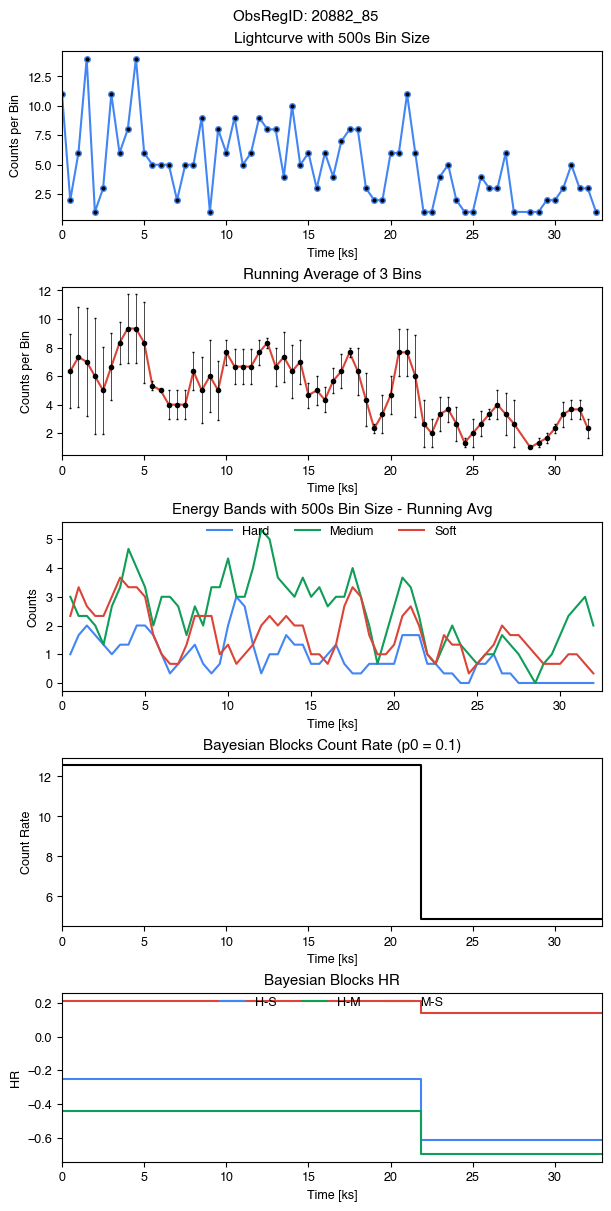

Name: 2CXO J050749.4+302404, ID: 21176-10, Date: 2018-11-24T19:02:48, Counts: 1240
RA  76.95604547242266 DEC  30.401188990787407
varB  1.0 varH  1.0 varM  0.5 varS  0.84 varINDEX  9.0


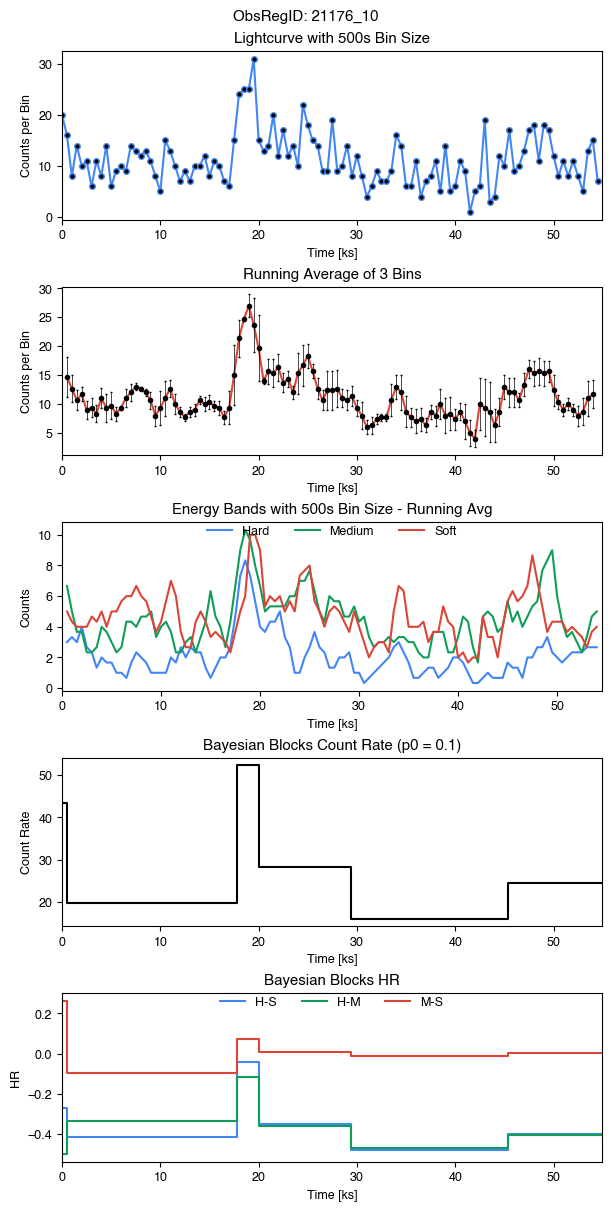

Name: 2CXO J050749.5+302404, ID: 21176-74, Date: 2018-11-24T19:02:48, Counts: 603
RA  76.95648249525055 DEC  30.40129920147878
varB  1.0 varH  1.0 varM  0.87 varS  0.65 varINDEX  9.0


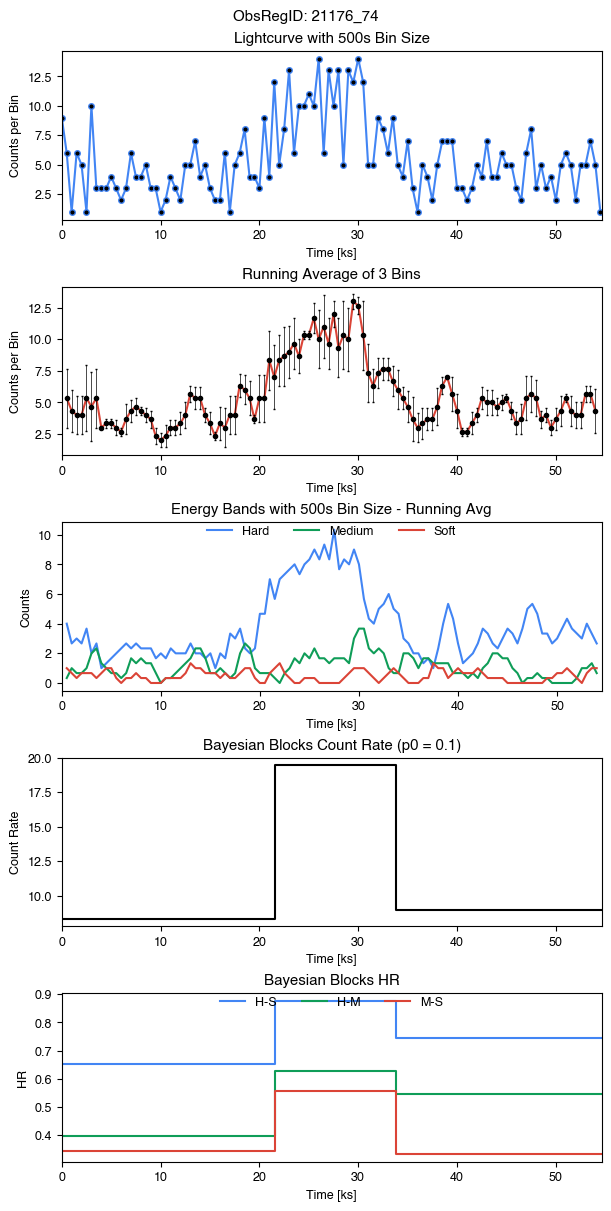

Name: 2CXO J053518.6-052033, ID: 21854-149, Date: 2018-12-05T10:50:03, Counts: 656
RA  83.82777717591813 DEC  -5.342700639711149
varB  0.94 varH  0.61 varM  0.18 varS  0.49 varINDEX  6.0


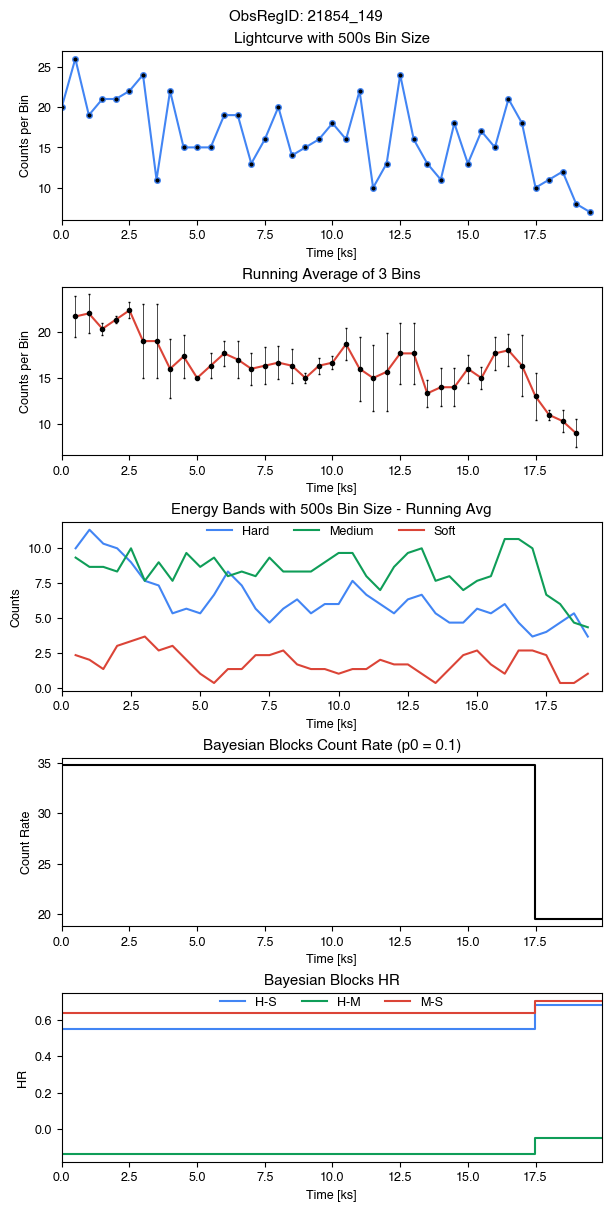

Name: 2CXO J053531.2-051532, ID: 21854-304, Date: 2018-12-05T10:50:03, Counts: 653
RA  83.88041115668136 DEC  -5.259133162201409
varB  0.98 varH  0.95 varM  0.38 varS  0.11 varINDEX  6.0


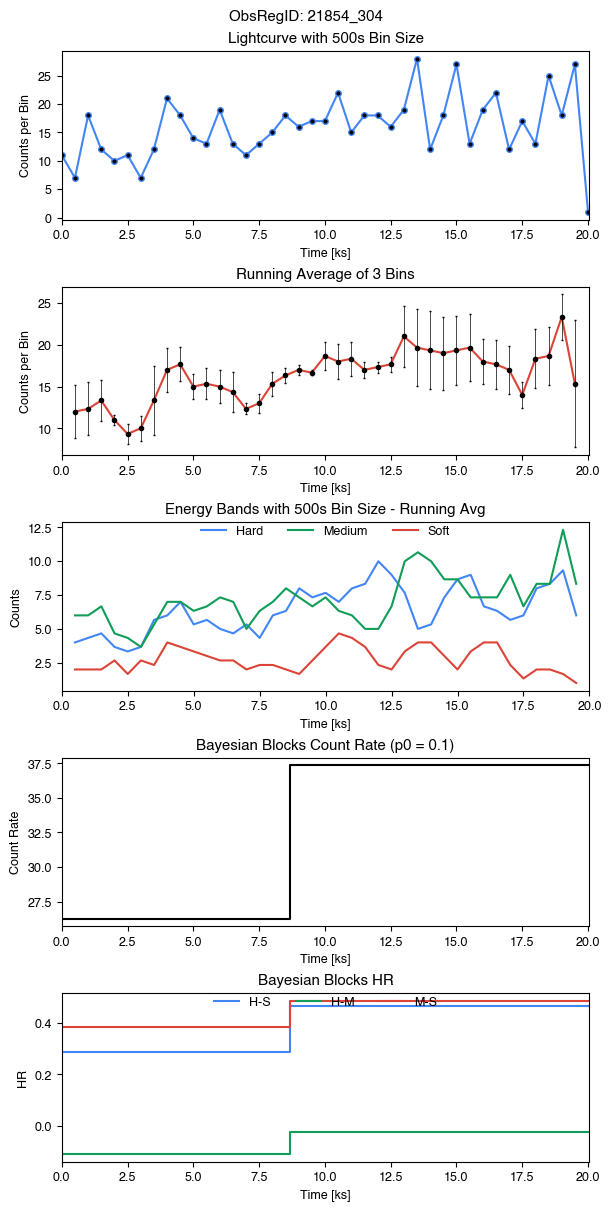

Name: 2CXO J053517.9-051613, ID: 21855-285, Date: 2018-12-11T23:29:31, Counts: 599
RA  83.8249471904196 DEC  -5.27038809718575
varB  1.0 varH  0.94 varM  0.39 varS  0.65 varINDEX  7.0


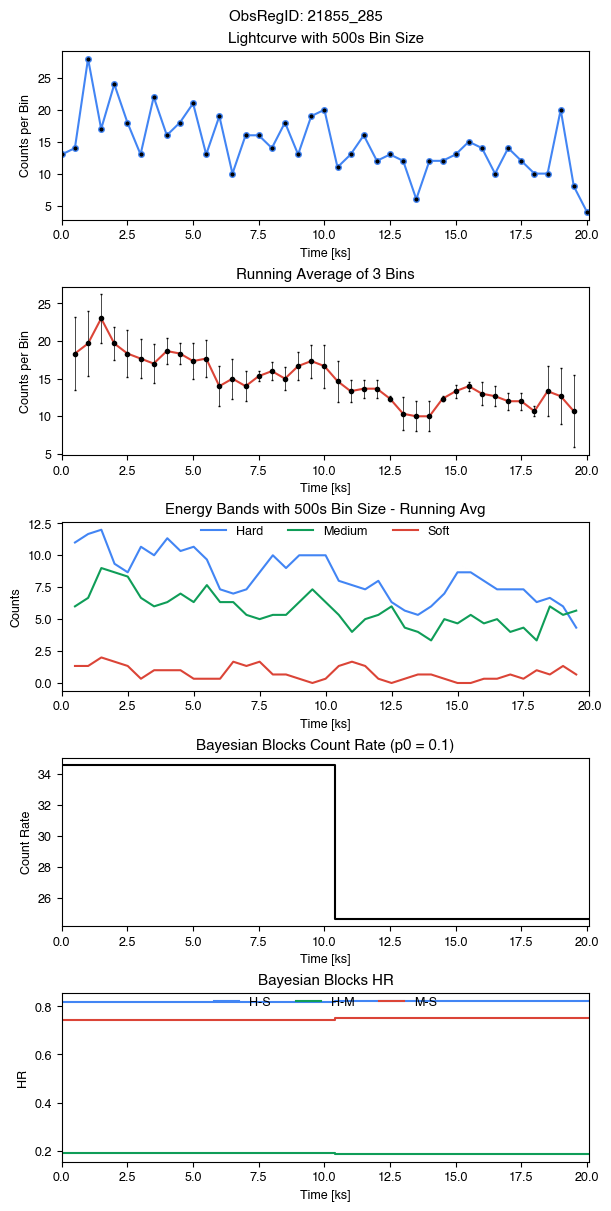

Name: 2CXO J093945.4-410355, ID: 22329-1, Date: 2020-08-21T22:55:49, Counts: 442
RA  144.9392627619717 DEC  -41.06546656568977
varB  0.99 varH  0.83 varM  0.12 varS  0.96 varINDEX  7.0


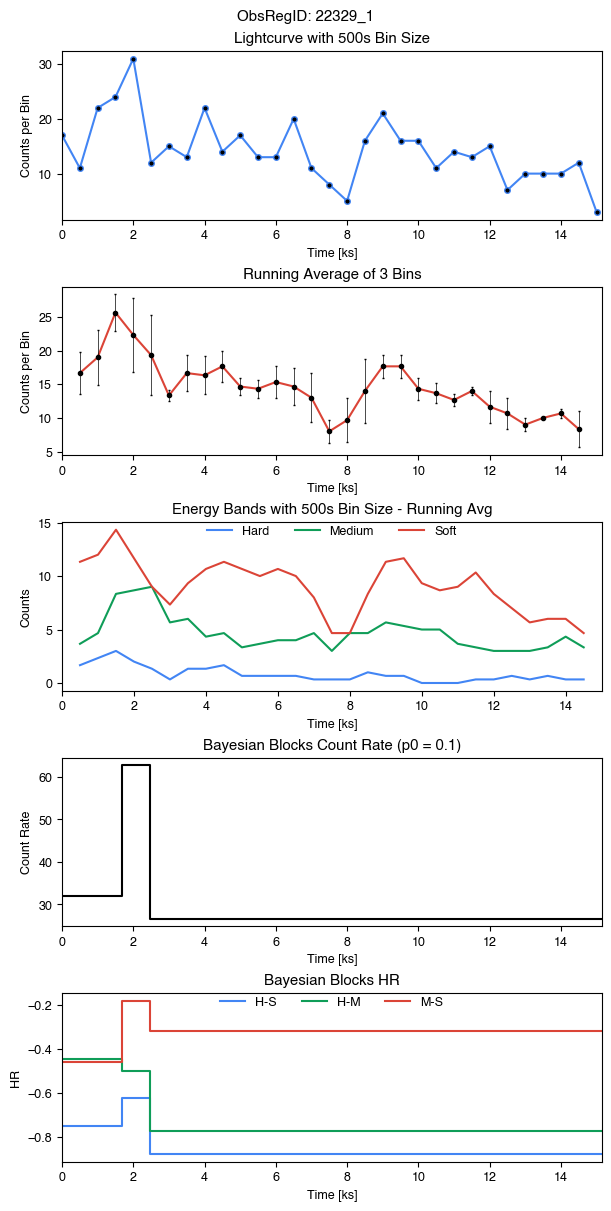

Name: 2CXO J093945.4-410355, ID: 22330-1, Date: 2020-09-13T22:08:32, Counts: 343
RA  144.9392627619717 DEC  -41.06546656568977
varB  1.0 varH  0.48 varM  1.0 varS  1.0 varINDEX  9.0


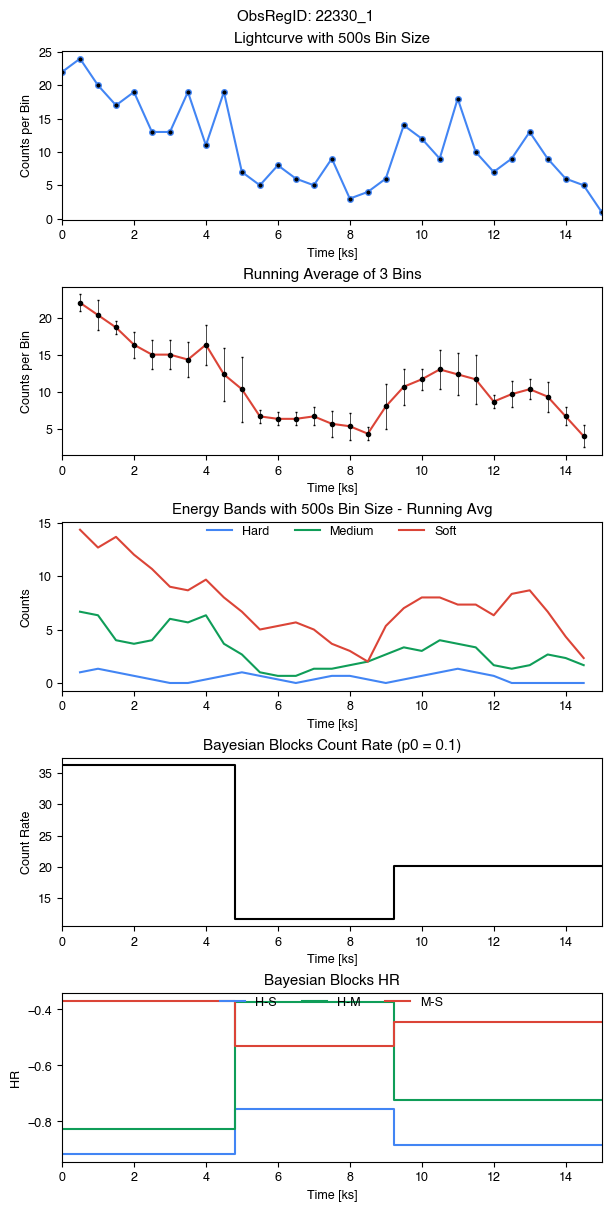

Name: 2CXO J050749.4+302404, ID: 23390-10, Date: 2020-12-13T00:58:49, Counts: 446
RA  76.95604547242266 DEC  30.401188990787407
varB  0.96 varH  0.87 varM  0.11 varS  0.74 varINDEX  6.0


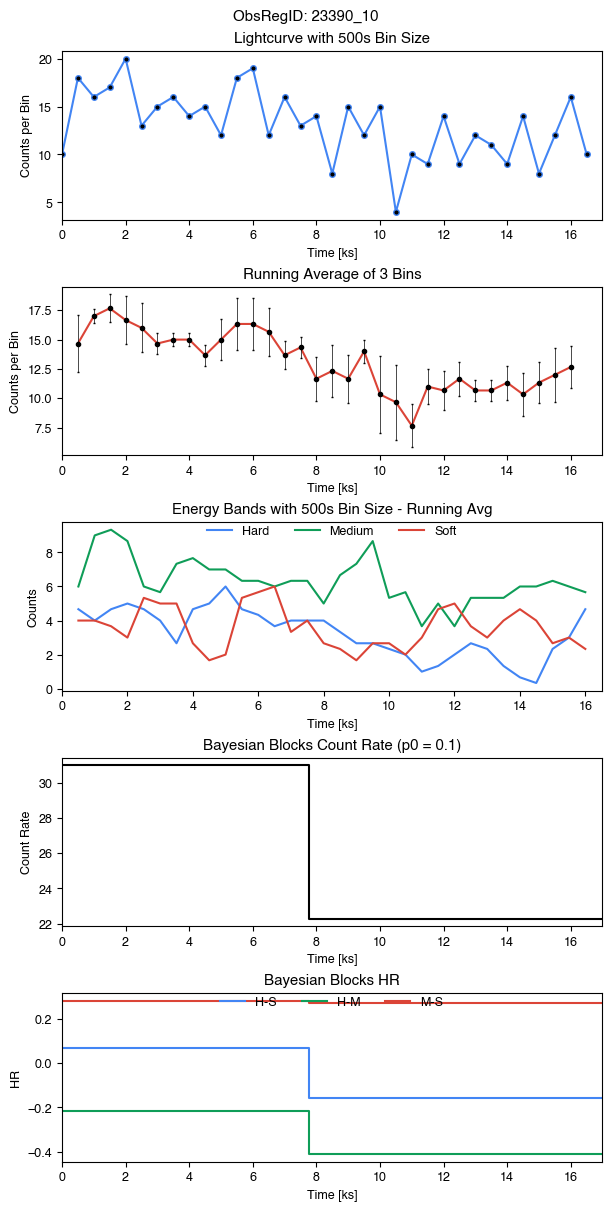

Name: 2CXO J084211.7-480632, ID: 24613-52, Date: 2020-08-19T22:36:31, Counts: 586
RA  130.54908982972046 DEC  -48.10914550728192
varB  1.0 varH  1.0 varM  1.0 varS  0.13 varINDEX  8.0


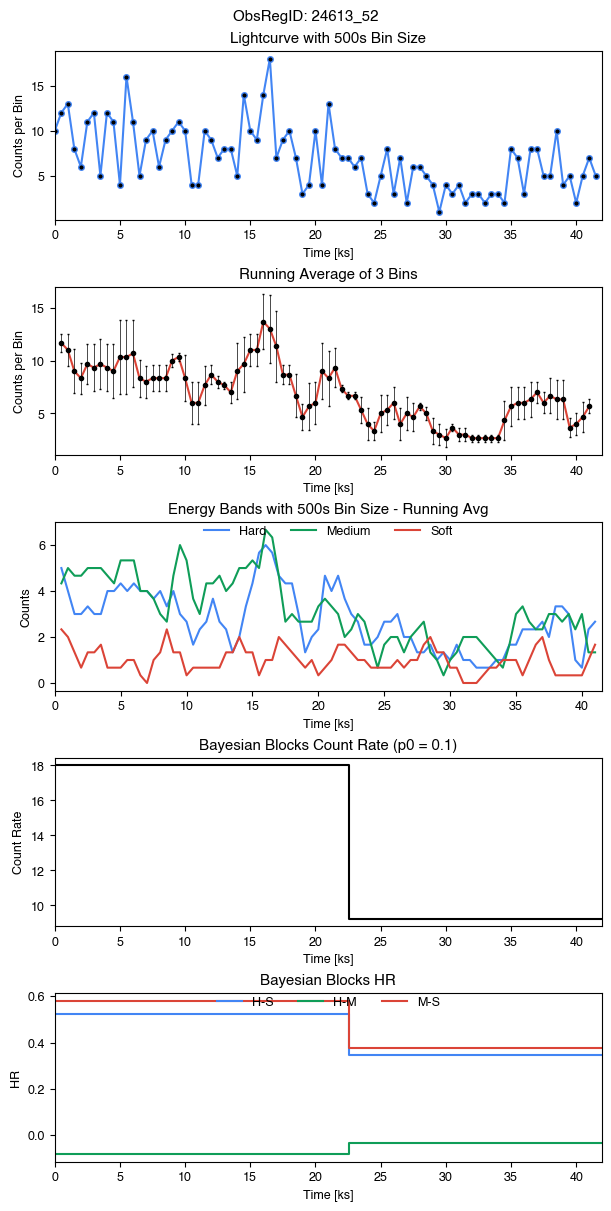

Name: 2CXO J050749.4+302404, ID: 24890-10, Date: 2020-12-07T21:20:28, Counts: 454
RA  76.95604547242266 DEC  30.401188990787407
varB  1.0 varH  1.0 varM  0.37 varS  0.47 varINDEX  7.0


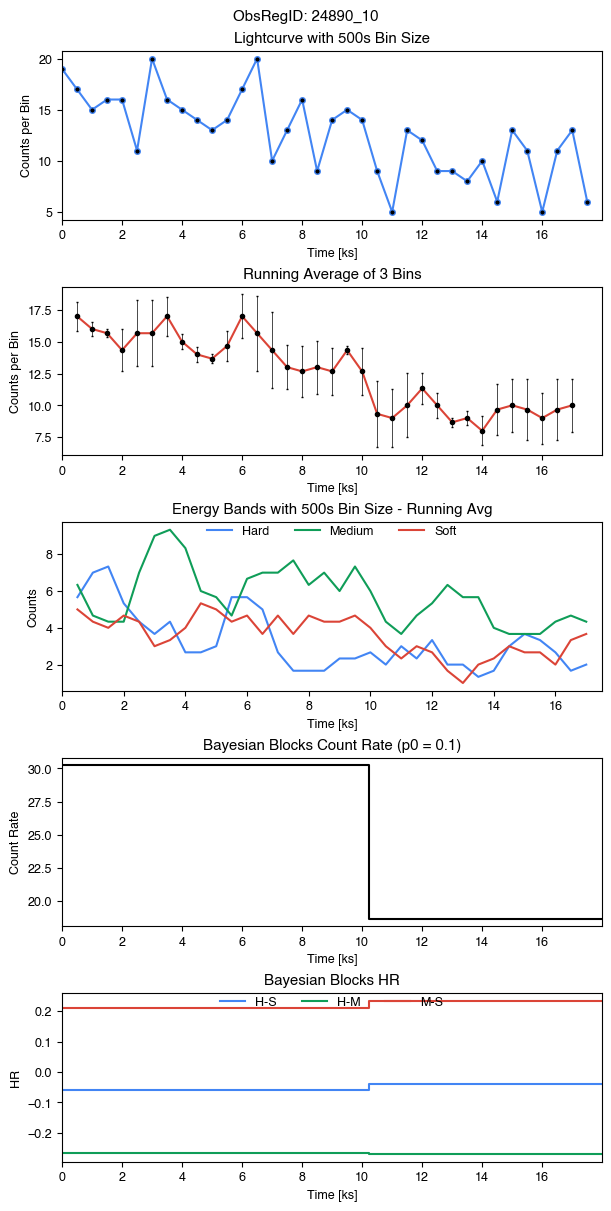

In [43]:
df_properties_anomalies = df_dips2

years = range(1999,2023)
years_string = [str(year) for year in years]
pattern = '|'.join(years_string)
df_properties_anomalies_filt = df_properties_anomalies[df_properties_anomalies['gti_obs'].str.contains(pattern)]

potential_anomalies = df_properties_anomalies_filt['obsreg_id']
# potential_anomalies = df_select['obsreg_id']
print(len(potential_anomalies))
keep = potential_anomalies.values[0:800]


# keep = ['13814_86','2540_253','633_2117']
# keep = ['6442_37','11231_250','5424_145','16000_221']
# keep = ['3012_53','3744_830','4373_662','4396_2625','13117_169','13653_40','6291_253']
# keep = ['12330_2071','10135_343','11073_116','11073_116','13951_16']
# keep = potential_anomalies.values
# keep = ['9912_482']
years = range(2015,2023)
# Image producer
# keep = all_ids[50000:55000]
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in keep).groupby('obsreg_id')
for id_name, dfi in df_eventfiles_group_filtered:
    dfi.sort_values(by='time', inplace = True) 
    dfi.reset_index(drop=True, inplace = True)
    obsid = id_name.split("_")[0]
    regionid = id_name.split("_")[1]
    # Get property columns
    name = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].name.values[0]
    ra = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].ra_x.values[0]
    dec = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].dec_x.values[0]
    date = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].gti_obs.values[0] 
    var_prob_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_b.values[0]
    var_prob_h = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_h.values[0]
    var_prob_m = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_m.values[0]
    var_prob_s = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_s.values[0] 
    var_index_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_index_b.values[0]
    # Get spectrum
    # pha_filename = [spec for spec in glob.iglob(f'{pha_folder}/acisf*pha3.fits.gz') if str(obsid) in spec and str(regionid) in spec][0]
    # ui.load_pha(pha_filename)
    # ui.ignore('0.:0.5,8.0:')
    # ui.subtract()
    # ui.notice_id(1,0.3,7.)
    # ui.group_counts(10)
    # ui.set_ylog()
    # ui.set_xlog()
    # ui.plot_data(color='red')
    # plt.xlim(1E-1,10)  
    # plt.show(

    if any(str(year) in date for year in years):
        print(f'Name: {name}, ID: {obsid}-{regionid}, Date: {date}, Counts: {len(dfi)}')
        print('RA ', str(ra), 'DEC ', str(dec))
        print('varB ', str(round(var_prob_b,2)), 'varH ', str(round(var_prob_h,2)),'varM ', str(round(var_prob_m,2)),'varS ', str(round(var_prob_s,2)),'varINDEX ', str(var_index_b))
        lightcurveplotterNEW(dfi,id_name,500,bb_p0=0.1,band_errors=False)
        # lightcurveplotterNEW(dfi,id_name,len(dfi)/100,bb_p0=0.1,band_errors=False)
    else:
        pass
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=True)
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=False)
    # hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=True)
    #hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=False)
    # hist3Dlog(dfi,id_name,16,24,24,'minmax',True,'plasma')